# Семинар 7. QC



In [ ]:
!pip3 install scanpy scrublet scikit-misc anndata2ri
!pip install rpy2==3.5.1

import os
os.kill(os.getpid(), 9)

## Подсчёт экспрессий

На этом практикуме мы не будем детально останавливаться на том, как запускаются основные пайплайны рассчёта экспрессий scRNA-Seq данных, потому что (а) это очень просто, обычно там 2-3 команды и (б) это очень ресурсоёмко, так что это бы заняло очень много времени.

В качестве задания вам будет предложено изучить, как работает инструмент `kallisto | bustools` и его обёртка <a href="https://github.com/pachterlab/kb_python">`kb_python`</a>, а также создать пайплайн анализа таких данных в NextFlow.

In [44]:
# Загрузка и прочтение датасета
import scanpy as sc
import seaborn as sns

sc.set_figure_params(dpi=150)
sns.set_style("ticks")

!wget https://cf.10xgenomics.com/samples/cell-exp/6.1.0/10k_PBMC_3p_nextgem_Chromium_X/10k_PBMC_3p_nextgem_Chromium_X_raw_feature_bc_matrix.h5
adata = sc.read_10x_h5("10k_PBMC_3p_nextgem_Chromium_X_raw_feature_bc_matrix.h5")
adata.var_names_make_unique()

--2022-12-30 14:21:15--  https://cf.10xgenomics.com/samples/cell-exp/6.1.0/10k_PBMC_3p_nextgem_Chromium_X/10k_PBMC_3p_nextgem_Chromium_X_raw_feature_bc_matrix.h5
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.0.173, 104.18.1.173, 2606:4700::6812:1ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.0.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62760214 (60M) [binary/octet-stream]
Saving to: ‘10k_PBMC_3p_nextgem_Chromium_X_raw_feature_bc_matrix.h5.1’

10k_PBMC_3p_nextgem 100%[===================>]  59.85M   137MB/s    in 0.4s    

2022-12-30 14:21:16 (137 MB/s) - ‘10k_PBMC_3p_nextgem_Chromium_X_raw_feature_bc_matrix.h5.1’ saved [62760214/62760214]



/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


## Фильтрация пустых капель

Посмотрим, какую матрицу мы прочитали (сколько в ней содержится клеток). Ожидаем мы порядка 10000 клеток.

In [45]:
adata

AnnData object with n_obs × n_vars = 2299294 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

Большинство из «клеток» — это на самом деле пустые капли. Как их отфильтровать? Давайте посмотрим на распределение числа UMI на клетку.

In [49]:
import pandas as pd
import numpy as np

pd.Series(adata.X.sum(axis=1).A.T[0]).value_counts()

28.0       3377
27.0       3321
25.0       3315
26.0       3265
24.0       3146
           ... 
7649.0        1
19455.0       1
11913.0       1
3210.0        1
8536.0        1
Length: 8098, dtype: int64

Уже здесь видно, что существует очень много клеток с 1-5 каунтами. Очевидно, это пустые клетки, и их очень много, это усложнит дальнейший анализ — давайте отфильтруем все клетки, у которых меньше 10 UMI, как в принципе пустые. Посмотрим на распределение оставшихся:

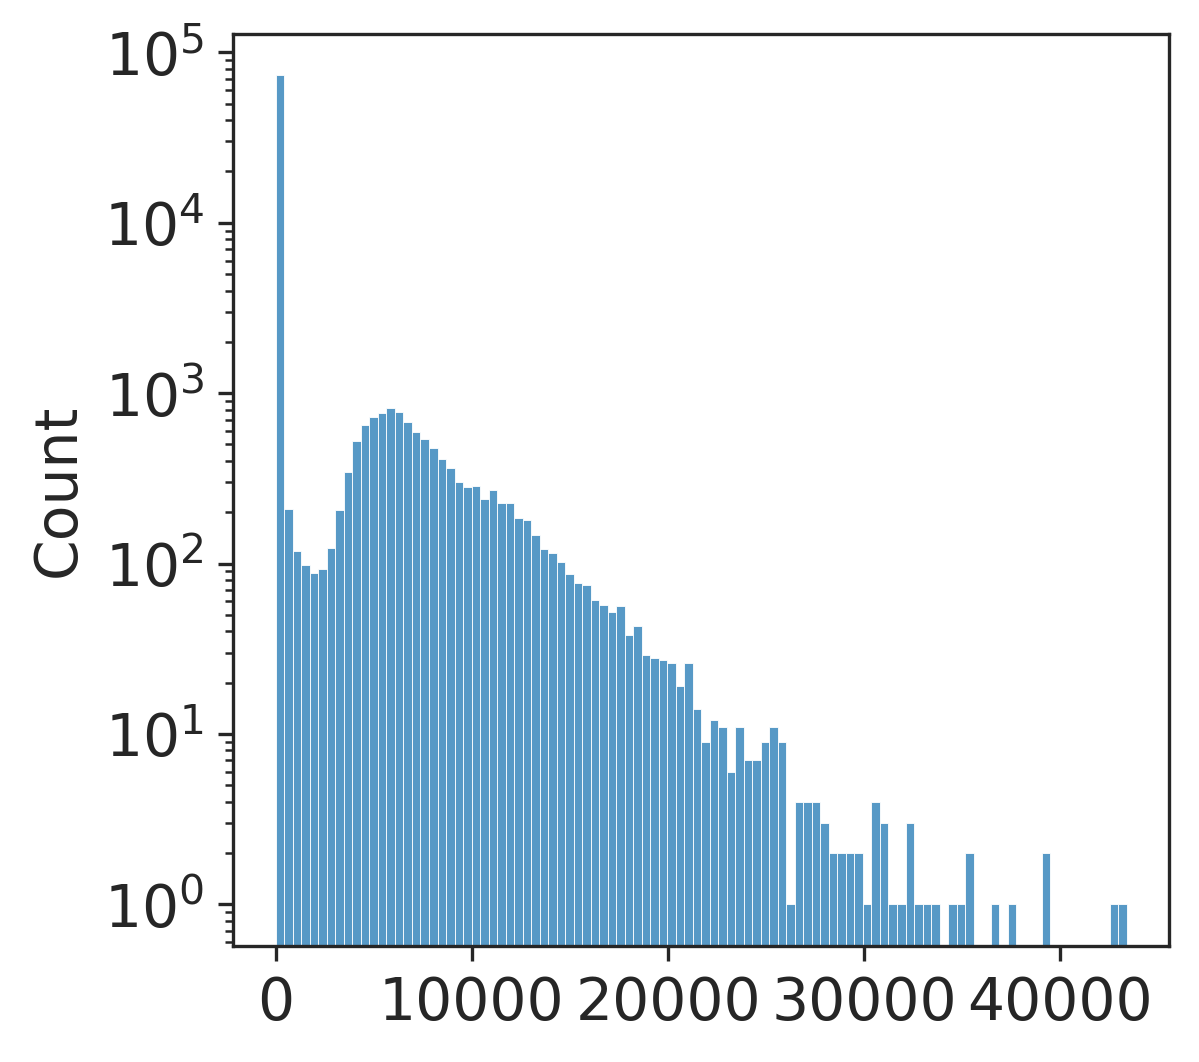

In [50]:
min_umi = 10
adata = adata[adata.X.sum(axis=1).A.T[0] >= min_umi]

ax = sns.histplot(adata.X.sum(axis=1).A.T[0], bins=100)
ax.set_yscale("log")

Это логарифмическая шкала (иначе сигнал от малых клеток будет слишком сильным). Но видно, что в целом у нашего распределения есть две моды, по которым клетки можно разделить. Попробуем построить распределение логарифма числа каунтов на клетку.

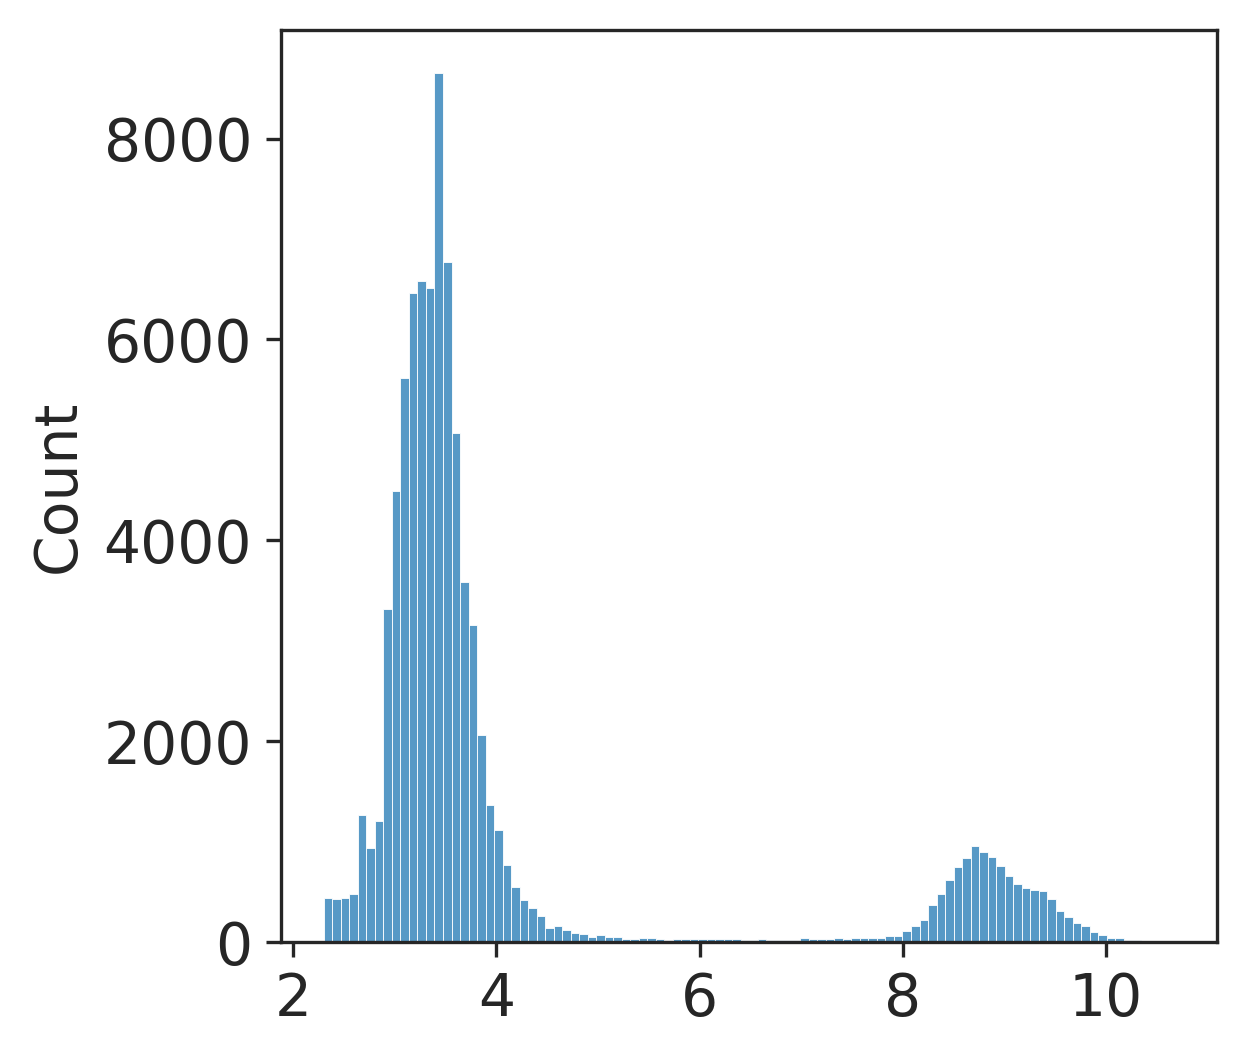

In [51]:
ax = sns.histplot(np.log(adata.X.sum(axis=1).A.T[0]), bins=100)

### EM-алгоритм

Мы видим два хороших распределения. Первое, что приходит в голову, — это реализация EM-алгоритма. Давайте попробуем.

phi: 0.11704941826439122
mu_real: 9.210340371976184
mu_empty: 2.302585092994046
sigma_real: 1
sigma_empty: 1


Text(0.5, 1.0, 'Start position')

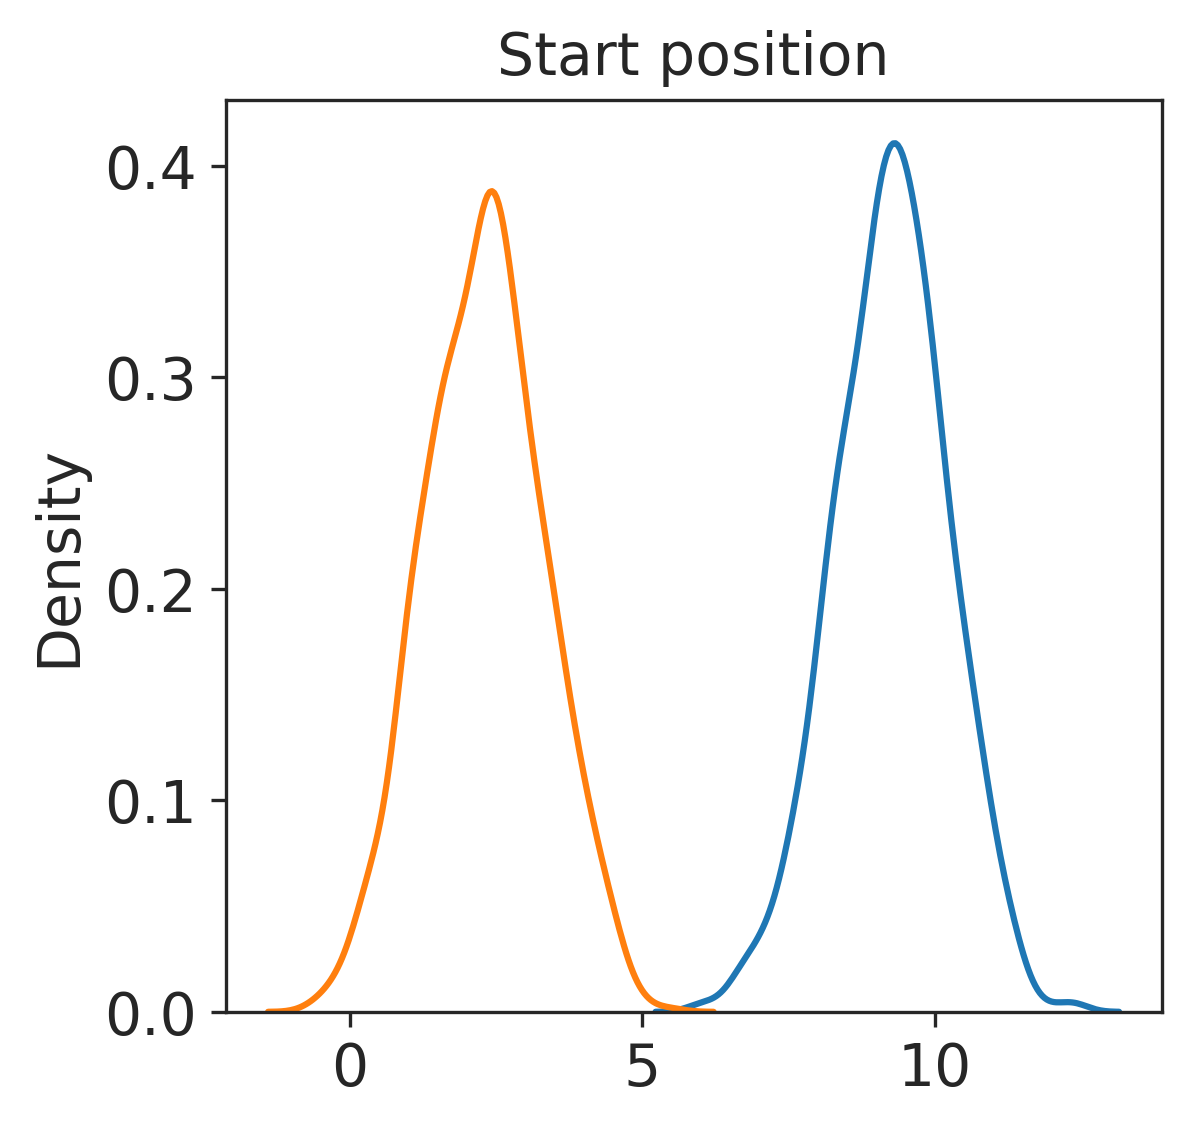

In [7]:
import scipy.stats as stats

X = np.log(adata.X.sum(axis=1).A.T[0])
expected_cells = 10000 / len(adata)

params = {
  "phi" : expected_cells,
  "mu_real" : np.log(10000),
  "mu_empty" : np.log(10),
  "sigma_real" : 1,
  "sigma_empty" : 1
}

for param in params:
  print(f"{param}: {params[param]}")

params_start = params.copy()

start_real = stats.norm(params["mu_real"], params["sigma_real"]).rvs(size=1000)
start_empty = stats.norm(params["mu_empty"], params["sigma_empty"]).rvs(size=1000)

ax = sns.kdeplot(start_real)
ax = sns.kdeplot(start_empty)
ax.set_title("Start position")

In [8]:
import scipy.stats as stats
from scipy.special import logsumexp

def E_step(X, params, draw=False):
  LogLikelihood = np.log([
      stats.norm(params["mu_empty"], params["sigma_empty"]).pdf(X), 
      stats.norm(params["mu_real"], params["sigma_real"]).pdf(X)
  ])
  logPrior = np.log([1 - params["phi"], params["phi"]])
  logNum = logPrior + LogLikelihood.T
  RealSoftMax = logsumexp(logNum, axis=1)
  probabilities = np.exp(logNum - np.array([RealSoftMax]).T)
  return RealSoftMax, probabilities

In [9]:
def M_step(X, params, probabilities):
  prob_empty = probabilities[:, 0]
  prob_real = probabilities[:, 1]

  # Вычисление новых значений
  phi = params["phi"]

  mu_empty = prob_empty.dot(X) / np.sum(prob_empty)
  mu_real = prob_real.dot(X) / np.sum(prob_real)

  sigma_empty = (np.sum(prob_empty * (X - mu_empty) ** 2) / np.sum(prob_empty)) ** 0.5
  sigma_real = (np.sum(prob_real * (X - mu_real) ** 2) / np.sum(prob_real)) ** 0.5
  
  return {
      "phi" : phi,
      "mu_empty" : mu_empty,
      "mu_real" : mu_real,
      "sigma_empty": sigma_empty,
      "sigma_real": sigma_real
  }

In [10]:
def run_EM(X, params):
    avg_allprob = []

    while True:
        allprob, probabilities = E_step(X, params)
        avg_allprob.append(np.mean(probabilities))
        if len(avg_allprob) > 2 and abs(avg_allprob[-1] - avg_allprob[-2]) < 0.00001:
            break
        params = M_step(X, params, probabilities)

    allprob, probabilities = E_step(X, params)
    forecasts = np.argmax(probabilities, axis=1)
    return forecasts, probabilities, avg_allprob

In [11]:
pred, prob, allprob = run_EM(X, params)

phi: 0.11704941826439122
mu_real: 9.210340371976184
mu_empty: 2.302585092994046
sigma_real: 1
sigma_empty: 1


Text(0.5, 1.0, 'Final position')

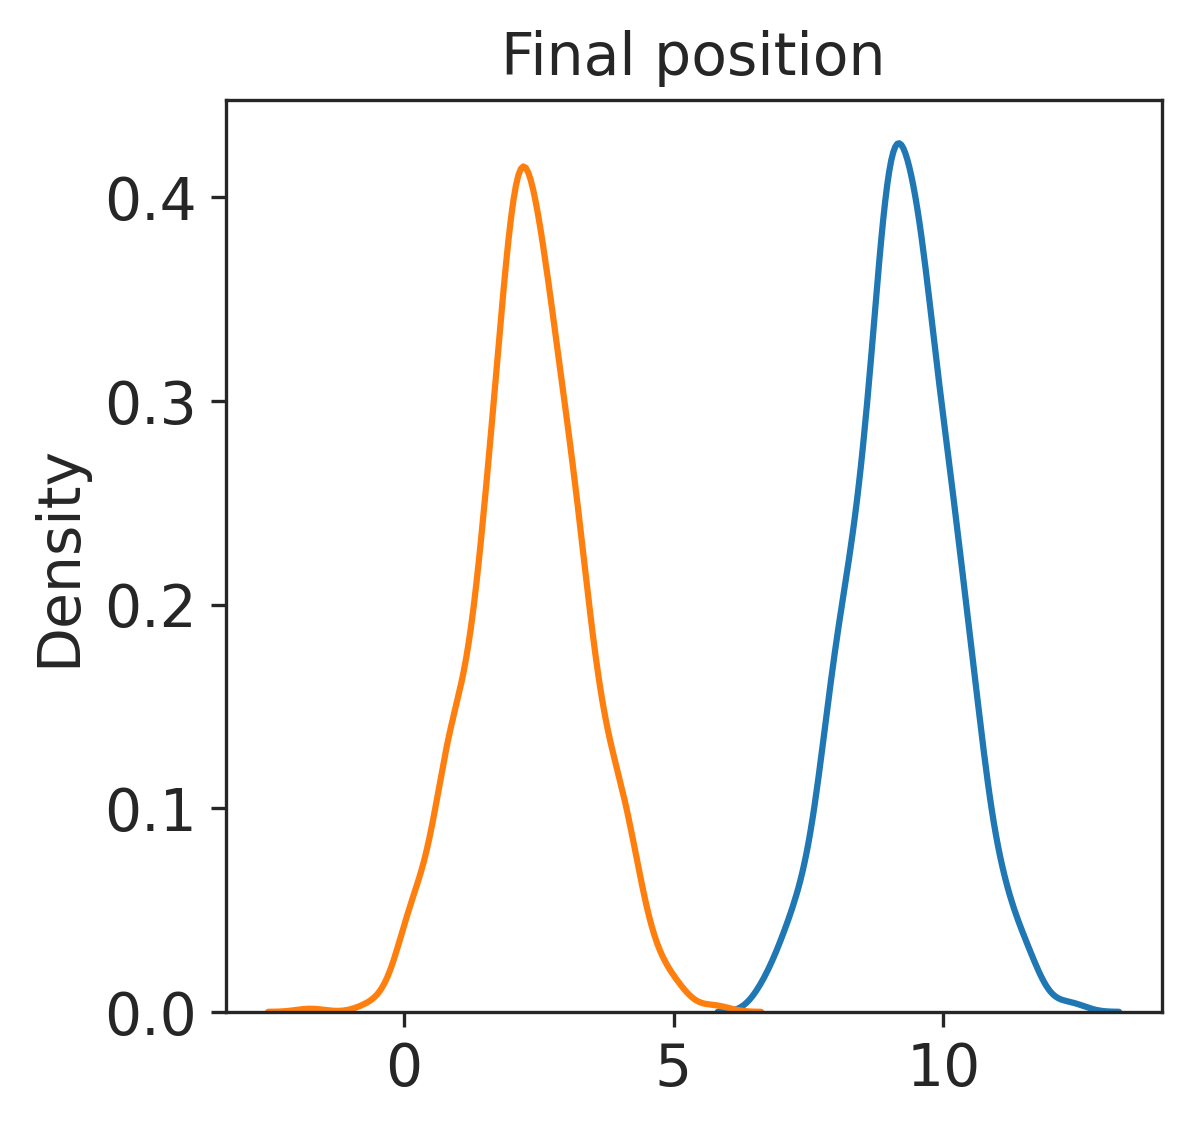

In [12]:
for param in params:
  print(f"{param}: {params[param]}")

final_real = stats.norm(params["mu_real"], params["sigma_real"]).rvs(size=1000)
final_empty = stats.norm(params["mu_empty"], params["sigma_empty"]).rvs(size=1000)

ax = sns.kdeplot(final_real)
ax = sns.kdeplot(final_empty)
ax.set_title("Final position")

Посмотрим, какое распределение каунтов у нас осталось в «настоящих» клетках:

<AxesSubplot: ylabel='Count'>

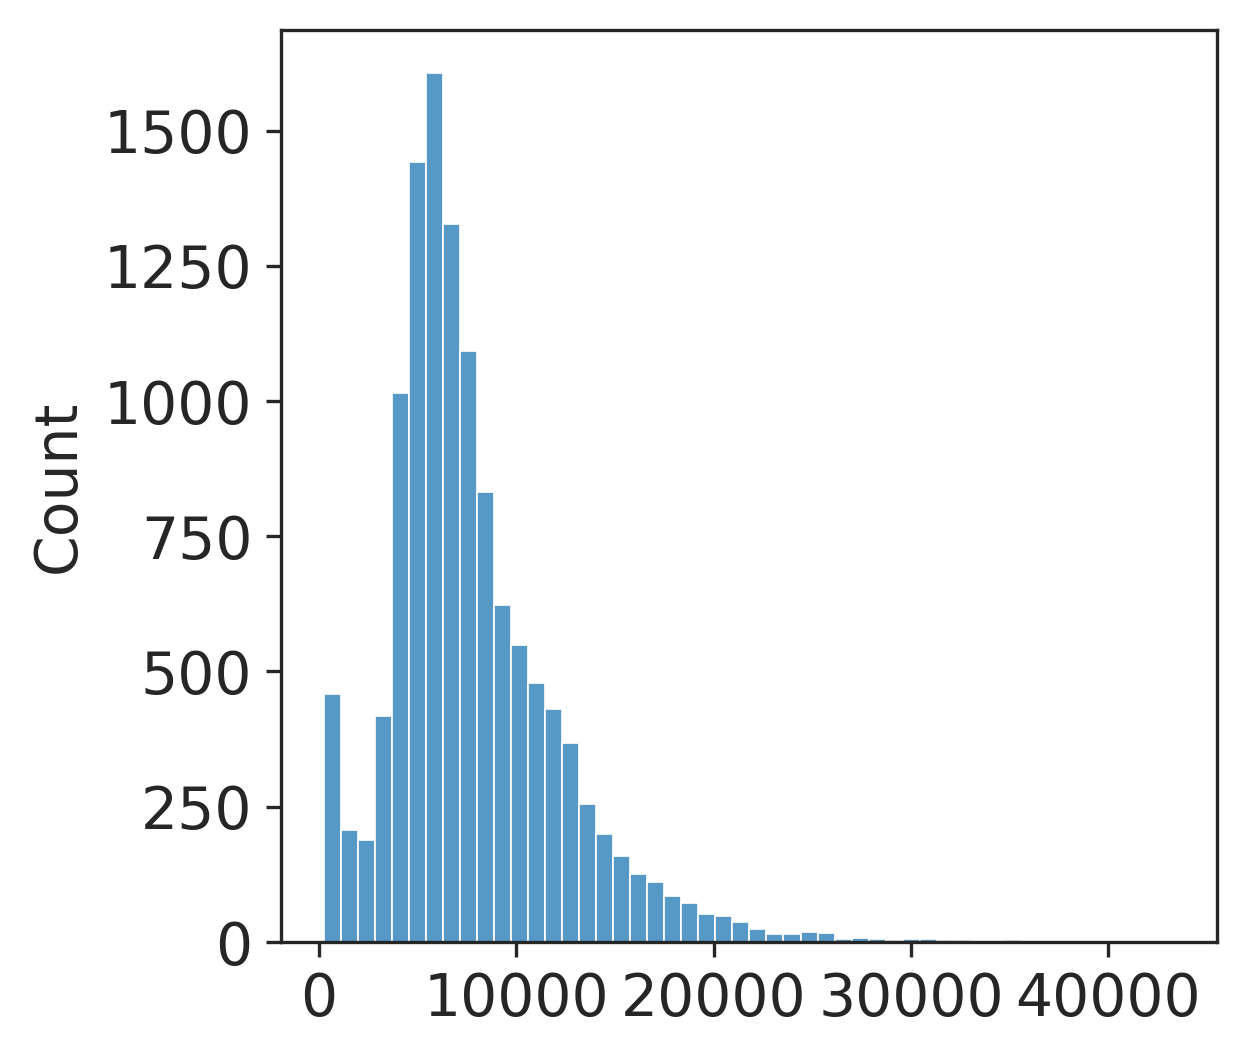

In [13]:
sns.histplot(adata.X.sum(axis=1).A.T[0][pred == 1], bins=50)

По всей видимости, центральный участок между двумя распределениями нам мешает. Давайте попытаемся расклассифицировать и его (добавим ещё одно нормальное распределение к нам в модель).

phi_real: 0.11704941826439122
phi_empty: 0.4414752908678044
mu_real: 9.210340371976184
mu_int: 6.214608098422191
mu_empty: 2.302585092994046
sigma_real: 1
sigma_int: 1
sigma_empty: 1


Text(0.5, 1.0, 'Start position')

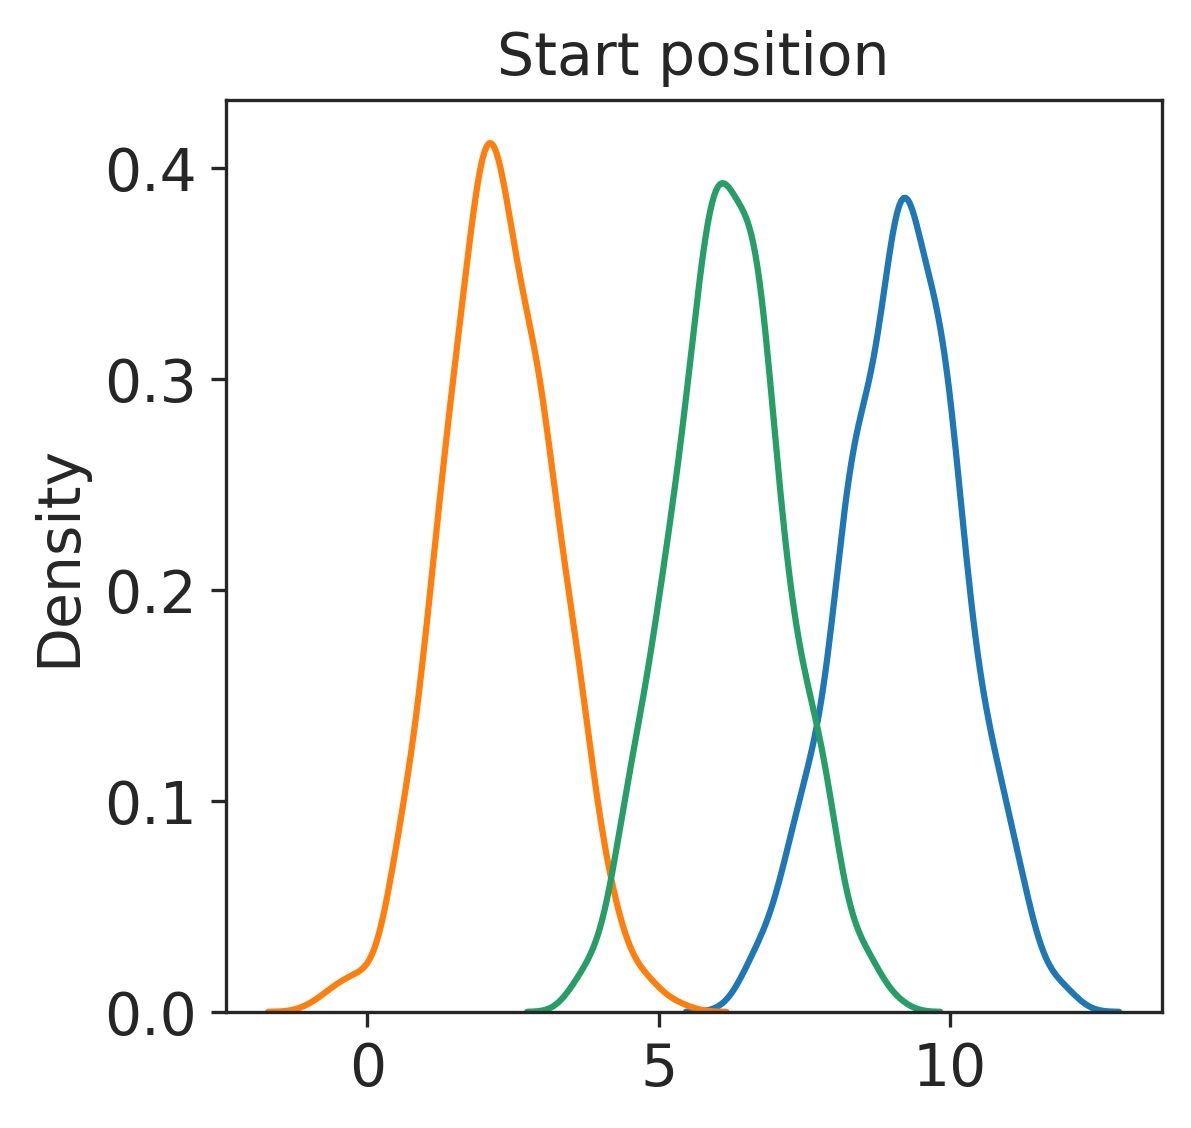

In [14]:
X = np.log(adata.X.sum(axis=1).A.T[0])
expected_cells = 10000 / len(adata)

params = {
  "phi_real" : expected_cells,
  "phi_empty" : (1 - expected_cells) / 2,
  "mu_real" : np.log(10000),
  "mu_int" : np.log(500),
  "mu_empty" : np.log(10),
  "sigma_real" : 1,
  "sigma_int" : 1,
  "sigma_empty" : 1
}

for param in params:
  print(f"{param}: {params[param]}")

params_start = params.copy()

start_real = stats.norm(params["mu_real"], params["sigma_real"]).rvs(size=1000)
start_int = stats.norm(params["mu_int"], params["sigma_int"]).rvs(size=1000)
start_empty = stats.norm(params["mu_empty"], params["sigma_empty"]).rvs(size=1000)

ax = sns.kdeplot(start_real)
ax = sns.kdeplot(start_empty)
ax = sns.kdeplot(start_int)
ax.set_title("Start position")

In [11]:
def E_step(X, params, draw=False):
  LogProb = np.log([
      stats.norm(params["mu_empty"], params["sigma_empty"]).pdf(X),
      stats.norm(params["mu_int"], params["sigma_int"]).pdf(X), 
      stats.norm(params["mu_real"], params["sigma_real"]).pdf(X)
  ])
  logPrior = np.log([params["phi_empty"], 1 - params["phi_real"] - params["phi_empty"], params["phi_real"]])
  logNum = logPrior + LogProb.T
  RealSoftMax = logsumexp(logNum, axis=1)
  probabilities = np.exp(logNum - np.array([RealSoftMax]).T)
  return RealSoftMax, probabilities

In [12]:
def M_step(X, params, probabilities):
  prob_empty = probabilities[:, 0]
  prob_int = probabilities[:, 1]
  prob_real = probabilities[:, 2]

  # Вычисление новых значений
  phi_empty = prob_empty.sum() / len(X)
  phi_real = prob_real.sum() / len(X)

  mu_empty = prob_empty.dot(X) / np.sum(prob_empty)
  mu_int = prob_int.dot(X) / np.sum(prob_int)
  mu_real = prob_real.dot(X) / np.sum(prob_real)

  sigma_empty = (np.sum(prob_empty * (X - mu_empty) ** 2) / np.sum(prob_empty)) ** 0.5
  sigma_int = (np.sum(prob_int * (X - mu_int) ** 2) / np.sum(prob_int)) ** 0.5
  sigma_real = (np.sum(prob_real * (X - mu_real) ** 2) / np.sum(prob_real)) ** 0.5

  return {
      "phi_empty" : phi_empty,
      "phi_real" : phi_real,
      "mu_empty" : mu_empty,
      "mu_int" : mu_int,
      "mu_real" : mu_real,
      "sigma_empty": sigma_empty,
      "sigma_int": sigma_int,
      "sigma_real": sigma_real
  }

In [13]:
def run_EM(X, params):
    avg_allprob = []

    while True:
        allprob, probabilities = E_step(X, params)
        avg_allprob.append(np.mean(probabilities))
        if len(avg_allprob) > 2 and abs(avg_allprob[-1] - avg_allprob[-2]) < 0.00001:
            break
        params = M_step(X, params, probabilities)

    allprob, probabilities = E_step(X, params)
    forecasts = np.argmax(probabilities, axis=1)
    return forecasts, probabilities, avg_allprob

In [18]:
pred, prob, avg_allprob = run_EM(X, params)

Text(0.5, 1.0, 'Final position')

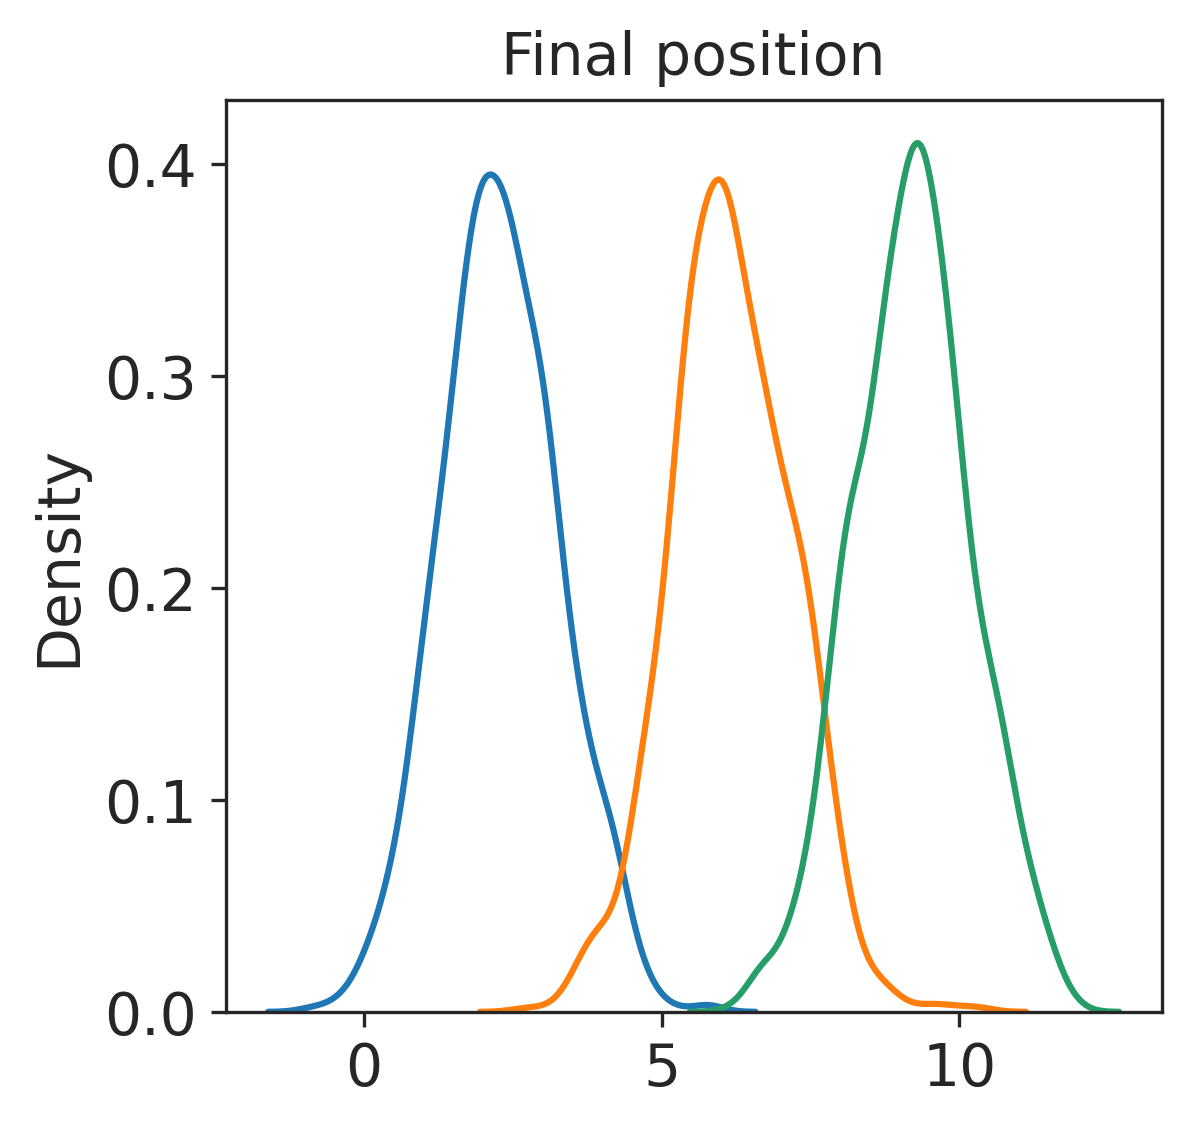

In [19]:
final_real = stats.norm(params["mu_real"], params["sigma_real"]).rvs(size=1000)
final_int = stats.norm(params["mu_int"], params["sigma_int"]).rvs(size=1000)
final_empty = stats.norm(params["mu_empty"], params["sigma_empty"]).rvs(size=1000)

ax = sns.kdeplot(final_empty)
ax = sns.kdeplot(final_int)
ax = sns.kdeplot(final_real)
ax.set_title("Final position")

<AxesSubplot: ylabel='Count'>

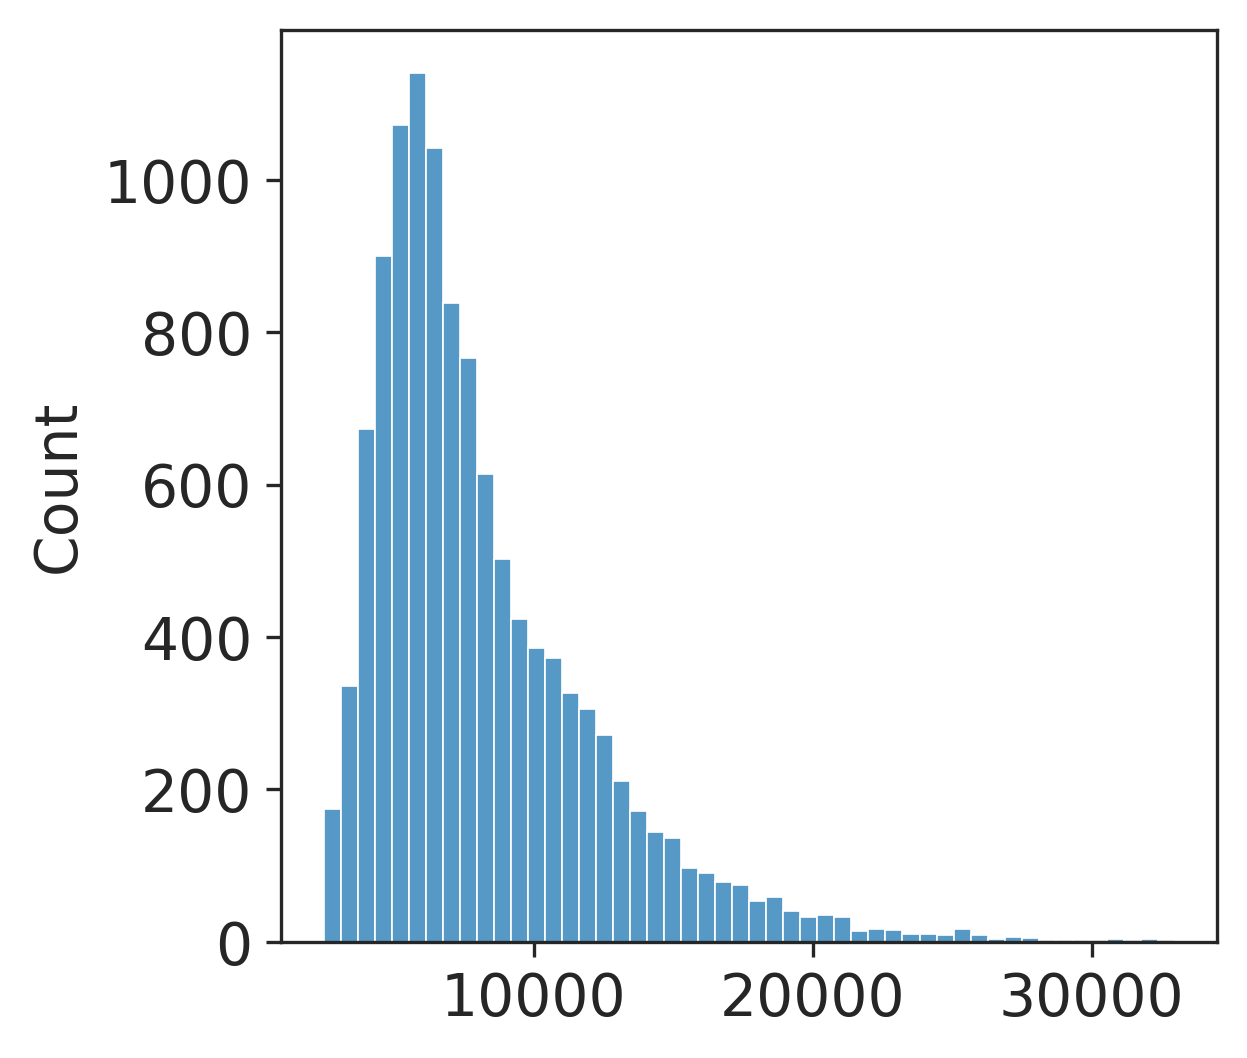

In [20]:
sns.histplot(adata.X.sum(axis=1).A.T[0][pred == 2], bins=50)

Теперь оставим только нормальные клетки:

In [21]:
adata_EM = adata[pred == 2]

In [22]:
adata_EM

View of AnnData object with n_obs × n_vars = 11540 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

### emptyDrops

Для поиска и фильтрации пустых клеток можно использовать также и инструмент `emptyDrops` из пакета DropletUtils для R. Иллюстрация того, как он работает:

In [23]:
!pip install --upgrade --no-cache-dir gdown
!apt-get install libgmp3-dev libcairo2-dev libharfbuzz-dev libfribidi-dev libudunits2-dev
!gdown 1W0TuuQospxcasOX5cQdhT_Xd-k7-QAck
!tar xf library.tar.gz
!cp -r /content/usr/local/lib/R /usr/local/lib/
!rm -r usr

import anndata2ri
import rpy2.robjects as ro
anndata2ri.activate()
!pip install rpy2==3.5.1
%load_ext rpy2.ipython
%R .libPaths("usr/local/lib/R/site-library/")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libharfbuzz-dev is already the newest version (1.7.2-1ubuntu1).
libudunits2-dev is already the newest version (2.2.26-1).
libcairo2-dev is already the newest version (1.15.10-2ubuntu0.1).
libfribidi-dev is already the newest version (0.19.7-2ubuntu0.1).
libgmp3-dev is already the newest version (2:6.1.2+dfsg-2ubuntu0.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
Downloading...
From: https://drive.google.com/uc?id=1W0TuuQospxcasOX5cQdhT_Xd-k7-QAck
To: /content/library.tar.gz
100% 2.33G/2.33G [00:22<00:00, 102MB/s]
tar: Removing leading `/' from member names
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/p

'/usr/local/li...,'/usr/lib/R/si...,'/usr/lib/R/li...


Запустим `emptyDrops`:

In [24]:
ro.r("library(DropletUtils)")
ro.globalenv["adata_raw"] = adata
df = ro.r('e.out <- emptyDrops(assay(adata_raw))')





Attaching package: ‘MatrixGenerics’



    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges, rowRanks,
    rowSdDiffs, rowSds, rowSums2, rowTabulates, rowVarDiffs, rowVars,
    rowWeightedMads, rowWeightedMeans, rowWeightedMedians,
    rowWeightedSds, rowWeightedVars





Attac

In [25]:
df

,Total,LogProb,PValue,Limited,FDR
AAACCCAAGAAGCCAC-1,45,NaN,NaN,-2147483648,NaN
AAACCCAAGACCATAA-1,56,NaN,NaN,-2147483648,NaN
AAACCCAAGAGCATAT-1,20,NaN,NaN,-2147483648,NaN
AAACCCAAGATACGAT-1,34,NaN,NaN,-2147483648,NaN
AAACCCAAGATGGTCG-1,30,NaN,NaN,-2147483648,NaN
...,...,...,...,...,...
TTTGTTGTCTCTCTTC-1,28,NaN,NaN,-2147483648,NaN
TTTGTTGTCTGCCTCA-1,37,NaN,NaN,-2147483648,NaN
TTTGTTGTCTGGCCGA-1,23,NaN,NaN,-2147483648,NaN
TTTGTTGTCTTGGCTC-1,32,NaN,NaN,-2147483648,NaN


Посмотрим на содержимое таблицы, которую выдаёт алгоритм, и выберем только те клетки, для которых FDR < 0.05.

<AxesSubplot: ylabel='Count'>

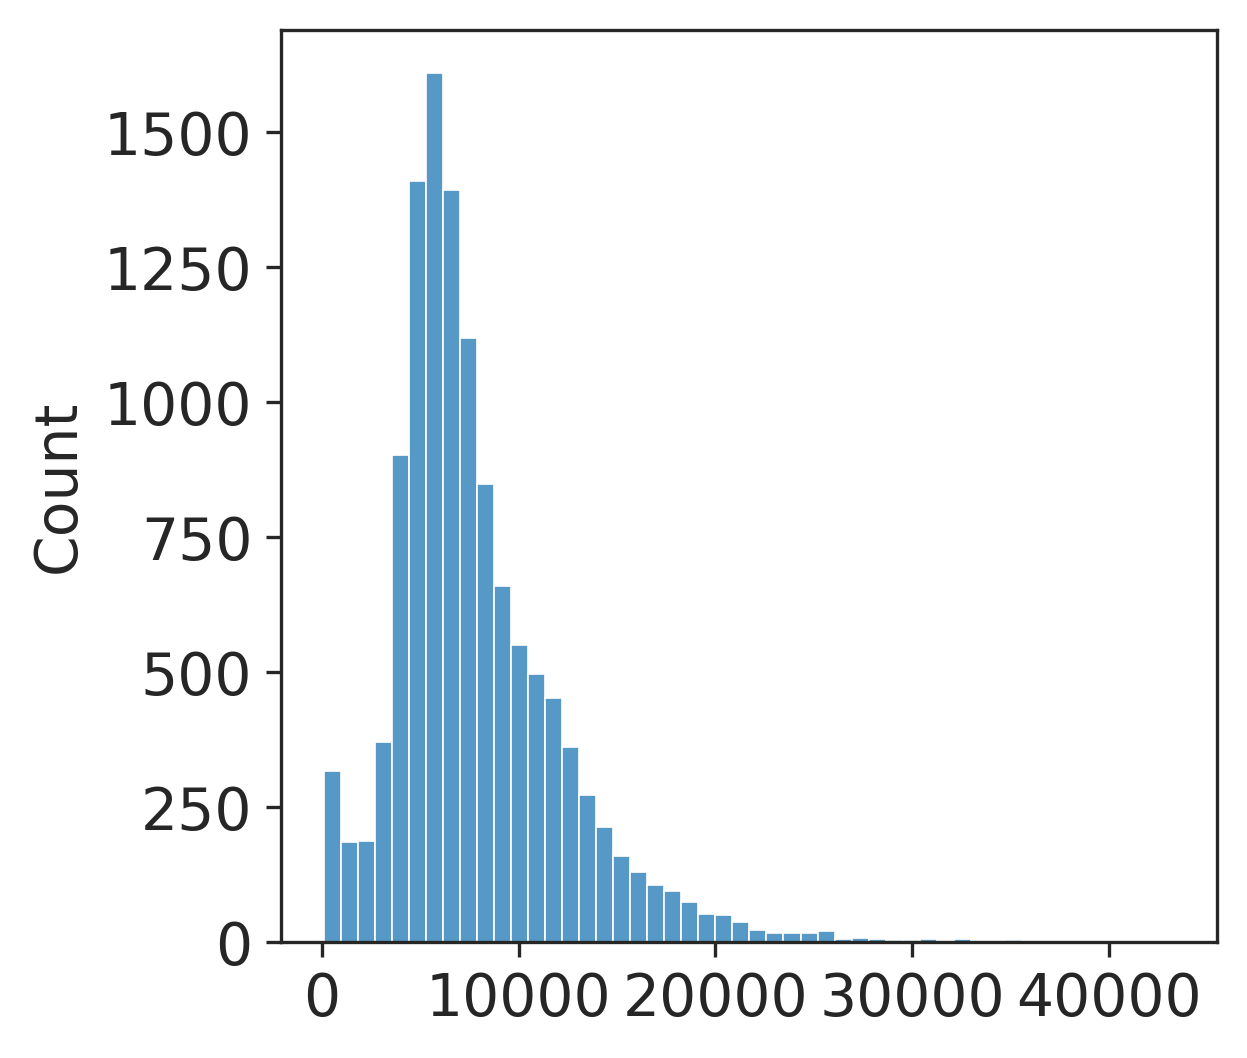

In [26]:
cell_barcodes = df.loc[df.FDR < 0.05]
adata_emptydrops = adata[cell_barcodes.index]
sns.histplot(adata_emptydrops.X.sum(axis=1).A.T[0], bins=50)

После работы этого алгоритма остаётся часть клеток, которая попадает в левую моду распределения UMI. Как вы думаете, почему?

## Иные метрики контроля качества

In [27]:
adata = adata_EM

Теперь для каждой клетки нам следует вычислить следующие характеристики:

1. Сколько UMI приходится на клетку? (снова, на всякий случай)
2. Сколько различных генов экспрессируется в клетке?
3. Какой процент митохондриальной экспрессии у нас наблюдается в клетке?

В пакете scanpy весь QC выполняется одной функцией. Но для начала надо явно обозначить гены, которые являются митохондриальными. Можно заранее выгрузить список этих генов, а можно воспользоваться знанием, что у человека все митохондриальные гены начинаются с *MT-*.

In [28]:
adata.var["mt"] = adata.var_names.str.startswith("MT-") # В датафрейме с описанием генов делаем отдельный столбик, в котором будет храниться True, если ген митохондриальный
adata.var.head()

<ipython-input-28-64b487020ef4>:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["mt"] = adata.var_names.str.startswith("MT-") # В датафрейме с описанием генов делаем отдельный столбик, в котором будет храниться True, если ген митохондриальный


,gene_ids,feature_types,genome,mt
MIR1302-2HG,ENSG00000243485,Gene Expression,GRCh38,False
FAM138A,ENSG00000237613,Gene Expression,GRCh38,False
OR4F5,ENSG00000186092,Gene Expression,GRCh38,False
AL627309.1,ENSG00000238009,Gene Expression,GRCh38,False
AL627309.3,ENSG00000239945,Gene Expression,GRCh38,False


In [29]:
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True) # Подсчитываем QC
adata.obs

,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
AAACCCAAGGCCCAAA-1,3022,12143.0,778.0,6.406984
AAACCCAAGTAATACG-1,2667,7811.0,493.0,6.311612
AAACCCAAGTCACACT-1,2934,9741.0,842.0,8.643877
AAACCCACAAAGCGTG-1,1525,5561.0,289.0,5.196907
AAACCCACAATCGAAA-1,2078,7399.0,656.0,8.866063
...,...,...,...,...
TTTGTTGGTTGGATCT-1,1602,6199.0,390.0,6.291337
TTTGTTGGTTTCTTAC-1,1902,4658.0,208.0,4.465436
TTTGTTGTCCATTTCA-1,1551,5059.0,374.0,7.392766
TTTGTTGTCTACACAG-1,2194,5037.0,289.0,5.737542


Видим, что у нас добавились несколько новых столбиков — они и будут нужны нам. Построим распределения числа митохондриальной экспрессии, UMI и числа генов.

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


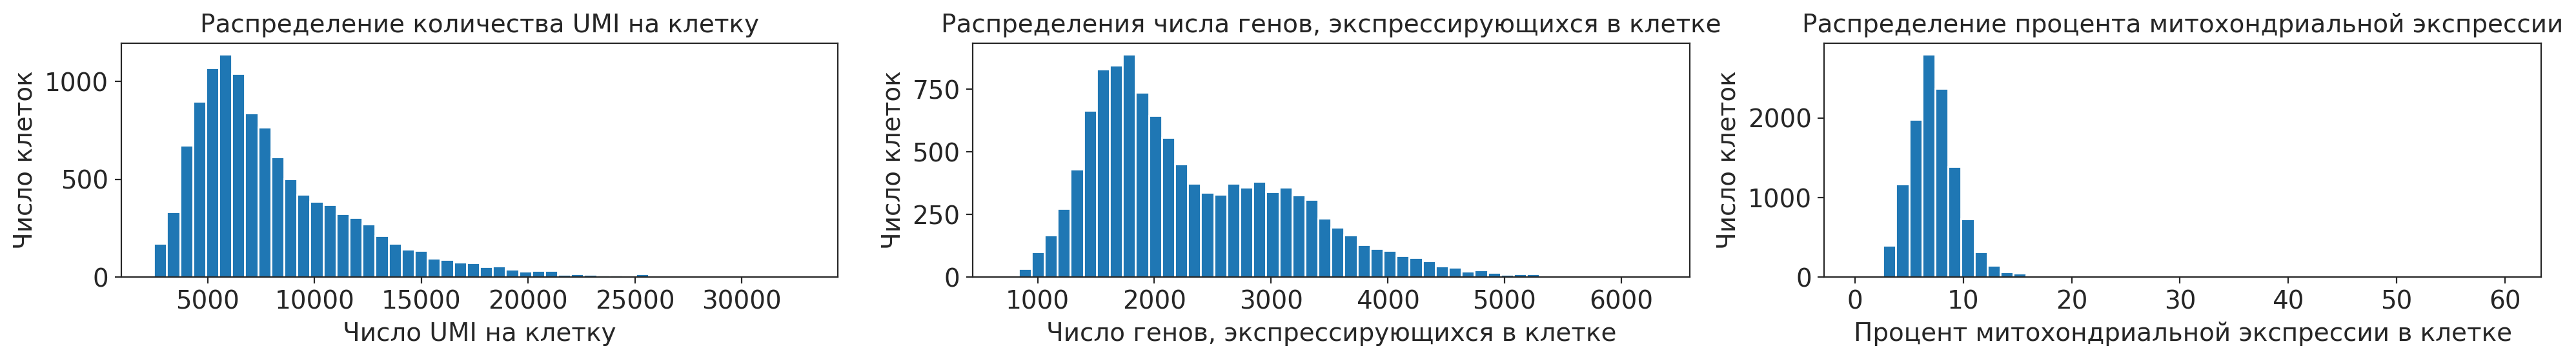

In [30]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(20, 3), dpi=100) # Создаём сетку, чтобы отрисовать три графика

# Отрисовываем распределение общего числа UMI
sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0], hist_kws={"alpha":1})
axs[0].set_xlabel("Число UMI на клетку")
axs[0].set_ylabel("Число клеток")
axs[0].set_title("Распределение количества UMI на клетку")

# Отрисовываем распределение числа генов по клеткам
sns.distplot(adata.obs["n_genes_by_counts"], kde=False, ax=axs[1], hist_kws={"alpha":1})
axs[1].set_xlabel("Число генов, экспрессирующихся в клетке")
axs[1].set_ylabel("Число клеток")
axs[1].set_title("Распределения числа генов, экспрессирующихся в клетке")

# Отрисовываем распределение митохондриальной экспрессии
sns.distplot(adata.obs["pct_counts_mt"], kde=False, ax=axs[2], hist_kws={"alpha":1})
axs[2].set_xlabel("Процент митохондриальной экспрессии в клетке")
axs[2].set_ylabel("Число клеток")
axs[2].set_title("Распределение процента митохондриальной экспрессии")

fig.tight_layout()

## Поиск дублетов

Следующим важным шагом при процессинге данных scRNA-Seq является определение дублетов. Тут мы воспользуемся алгоритмом `scrublet`. Концептуально принципы работы пакета мы рассматривали на лекции, сейчас разберём, как им пользоваться.

In [31]:
import scanpy.external as sce

sce.pp.scrublet(adata)

/usr/local/lib/python3.8/dist-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.19
Detected doublet rate = 4.8%
Estimated detectable doublet fraction = 61.1%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 7.8%


Теперь посмотрим на распределение scrublet score для наших данных, а также для симулированных дублетов:

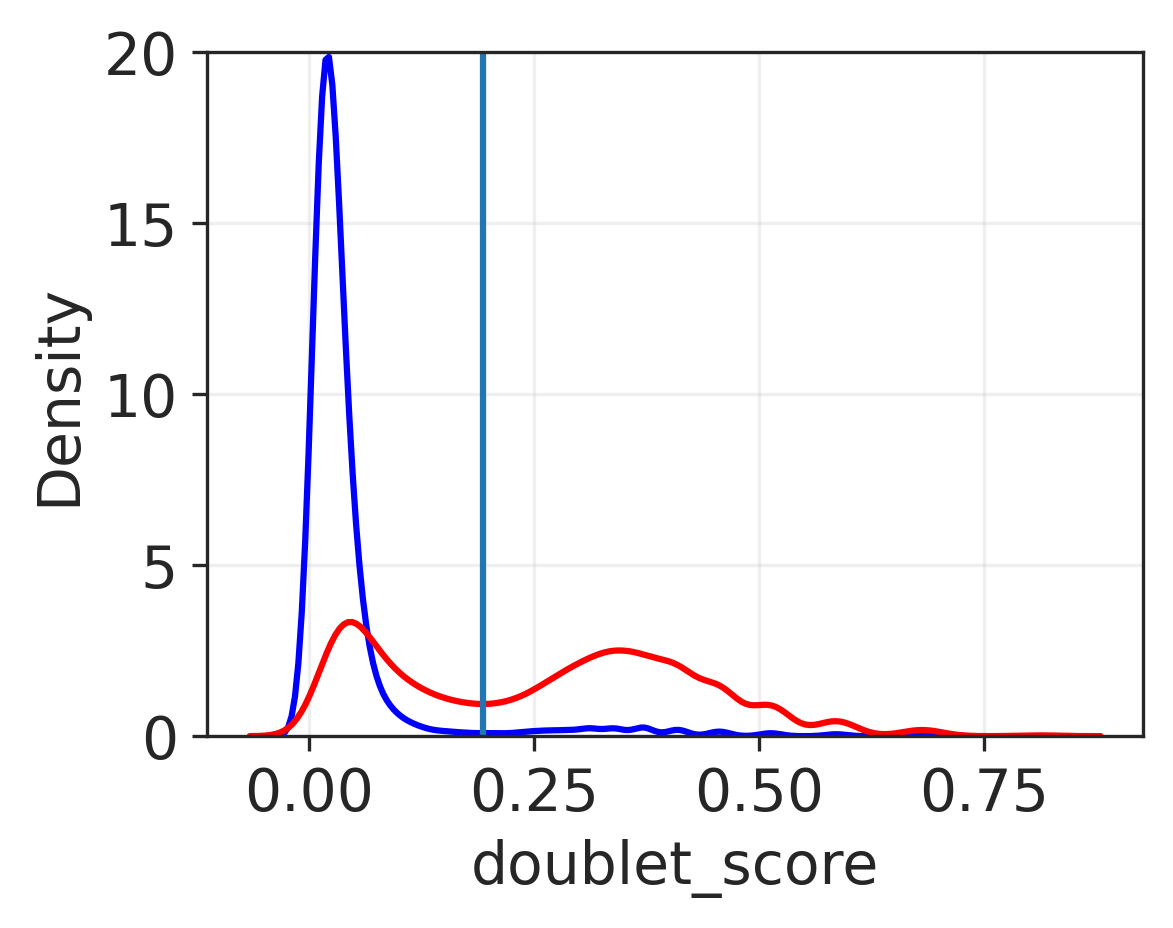

In [32]:
fig, ax = plt.subplots(figsize=(4, 3))

sns.kdeplot(adata.obs["doublet_score"], color="blue", ax=ax)
sns.kdeplot(adata.uns["scrublet"]["doublet_scores_sim"], color="red", ax=ax)
ax.plot([adata.uns["scrublet"]["threshold"], adata.uns["scrublet"]["threshold"]], [0, 20])
ax.set_ylim(0, 20)
ax.grid(alpha=0.3)

## Домашнее задание

### Задание 1

Протестируйте написанный нами EM-алгоритм на устойчивость к параметрам изначальной инициализации.

# Решение

Способы проверки устойчивости EM-алгоритма:
1. Изменение положения кластеров (распределений) относительно друг друга
2. Наложение кластеров друг на друга путем сближения значений:
  * $\mu$ (средних) кластеров
  * $\sigma$ (дисперсий) кластеров
3. Выполнение одновременно первых двух пунктов

Скачаем файл с экспрессиями, полученных в результате scRNA-seq

In [ ]:
import scanpy as sc
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

sc.set_figure_params(dpi=150)
sns.set_style("ticks")

!wget https://cf.10xgenomics.com/samples/cell-exp/6.1.0/10k_PBMC_3p_nextgem_Chromium_X/10k_PBMC_3p_nextgem_Chromium_X_raw_feature_bc_matrix.h5
adata = sc.read_10x_h5("10k_PBMC_3p_nextgem_Chromium_X_raw_feature_bc_matrix.h5")
adata.var_names_make_unique()

Заново инициализируем функции EM-алгоритма

In [52]:
def E_step(X, params, draw=False):
  LogProb = np.log([
      stats.norm(params["mu_empty"], params["sigma_empty"]).pdf(X),
      stats.norm(params["mu_int"], params["sigma_int"]).pdf(X), 
      stats.norm(params["mu_real"], params["sigma_real"]).pdf(X)
  ])
  logPrior = np.log([params["phi_empty"], 1 - params["phi_real"] - params["phi_empty"], params["phi_real"]])
  logNum = logPrior + LogProb.T
  RealSoftMax = logsumexp(logNum, axis=1)
  probabilities = np.exp(logNum - np.array([RealSoftMax]).T)
  return RealSoftMax, probabilities

In [53]:
def M_step(X, params, probabilities):
  prob_empty = probabilities[:, 0]
  prob_int = probabilities[:, 1]
  prob_real = probabilities[:, 2]

  # Вычисление новых значений
  phi_empty = prob_empty.sum() / len(X)
  phi_real = prob_real.sum() / len(X)

  mu_empty = prob_empty.dot(X) / np.sum(prob_empty)
  mu_int = prob_int.dot(X) / np.sum(prob_int)
  mu_real = prob_real.dot(X) / np.sum(prob_real)

  sigma_empty = (np.sum(prob_empty * (X - mu_empty) ** 2) / np.sum(prob_empty)) ** 0.5
  sigma_int = (np.sum(prob_int * (X - mu_int) ** 2) / np.sum(prob_int)) ** 0.5
  sigma_real = (np.sum(prob_real * (X - mu_real) ** 2) / np.sum(prob_real)) ** 0.5

  return {
      "phi_empty" : phi_empty,
      "phi_real" : phi_real,
      "mu_empty" : mu_empty,
      "mu_int" : mu_int,
      "mu_real" : mu_real,
      "sigma_empty": sigma_empty,
      "sigma_int": sigma_int,
      "sigma_real": sigma_real
  }

In [54]:
def run_EM(X, params):
    avg_allprob = []

    while True:
        allprob, probabilities = E_step(X, params)
        avg_allprob.append(np.mean(probabilities))
        if len(avg_allprob) > 2 and abs(avg_allprob[-1] - avg_allprob[-2]) < 0.00001:
            break
        params = M_step(X, params, probabilities)

    allprob, probabilities = E_step(X, params)
    forecasts = np.argmax(probabilities, axis=1)
    return forecasts, probabilities, avg_allprob

### Выполним первую проверку

Теперь поменяем местами кластеры. И посмотрим, как это повлияет на результаты EM-алгоритма.

phi_real: 0.11704941826439122
phi_empty: 0.4414752908678044
mu_real: 6.214608098422191
mu_int: 2.302585092994046
mu_empty: 9.210340371976184
sigma_real: 1
sigma_int: 1
sigma_empty: 1


Text(0.5, 1.0, 'Start position')

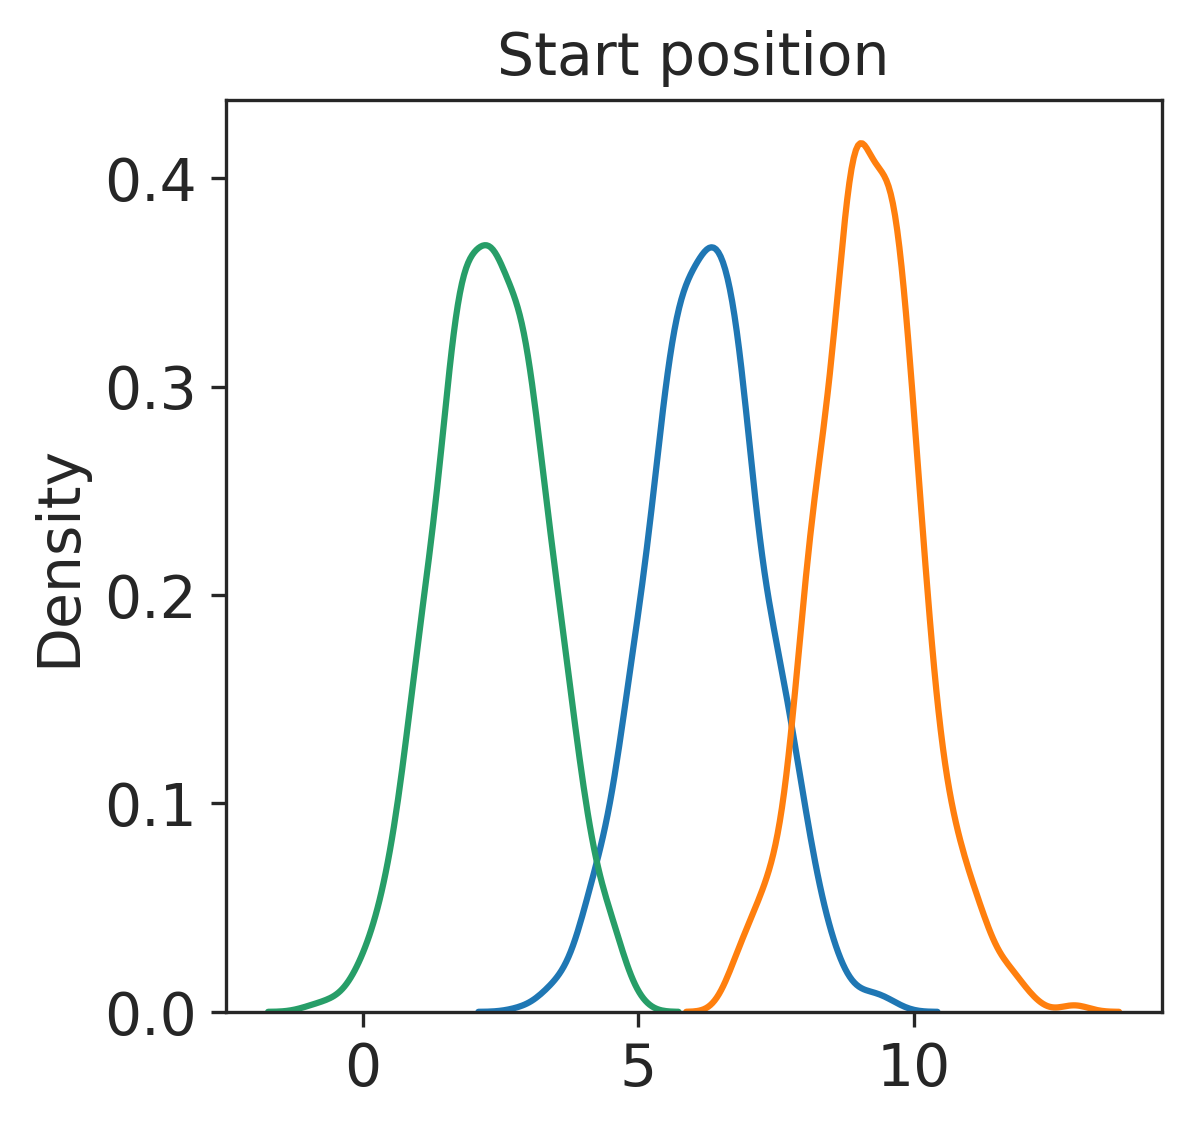

In [82]:
X = np.log(adata.X.sum(axis=1).A.T[0])
expected_cells = 10000 / len(adata)

params = {
  "phi_real" : expected_cells,
  "phi_empty" : (1 - expected_cells) / 2,
  "mu_real" : np.log(500),
  "mu_int" : np.log(10),
  "mu_empty" : np.log(10000),
  "sigma_real" : 1,
  "sigma_int" : 1,
  "sigma_empty" : 1
}

for param in params:
  print(f"{param}: {params[param]}")

params_start = params.copy()

start_real = stats.norm(params["mu_real"], params["sigma_real"]).rvs(size=1000)
start_int = stats.norm(params["mu_int"], params["sigma_int"]).rvs(size=1000)
start_empty = stats.norm(params["mu_empty"], params["sigma_empty"]).rvs(size=1000)

ax = sns.kdeplot(start_real)
ax = sns.kdeplot(start_empty)
ax = sns.kdeplot(start_int)
ax.set_title("Start position")

Text(0.5, 1.0, 'Final position')

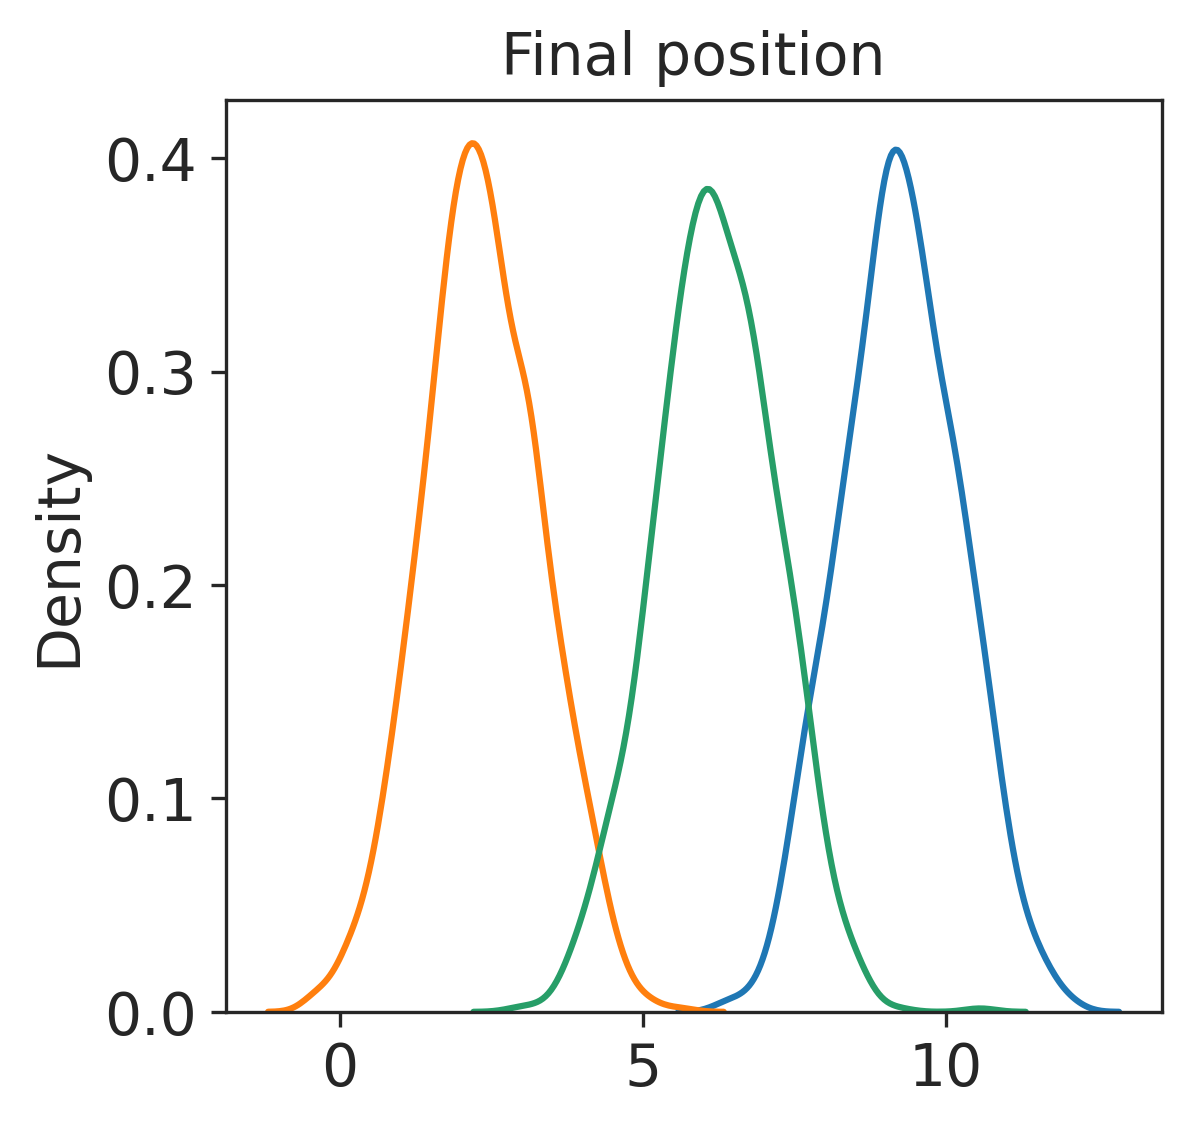

In [83]:
pred, prob, avg_allprob = run_EM(X, params)
final_real = stats.norm(params["mu_real"], params["sigma_real"]).rvs(size=1000)
final_int = stats.norm(params["mu_int"], params["sigma_int"]).rvs(size=1000)
final_empty = stats.norm(params["mu_empty"], params["sigma_empty"]).rvs(size=1000)

ax = sns.kdeplot(final_empty)
ax = sns.kdeplot(final_int)
ax = sns.kdeplot(final_real)
ax.set_title("Final position")

<AxesSubplot: ylabel='Count'>

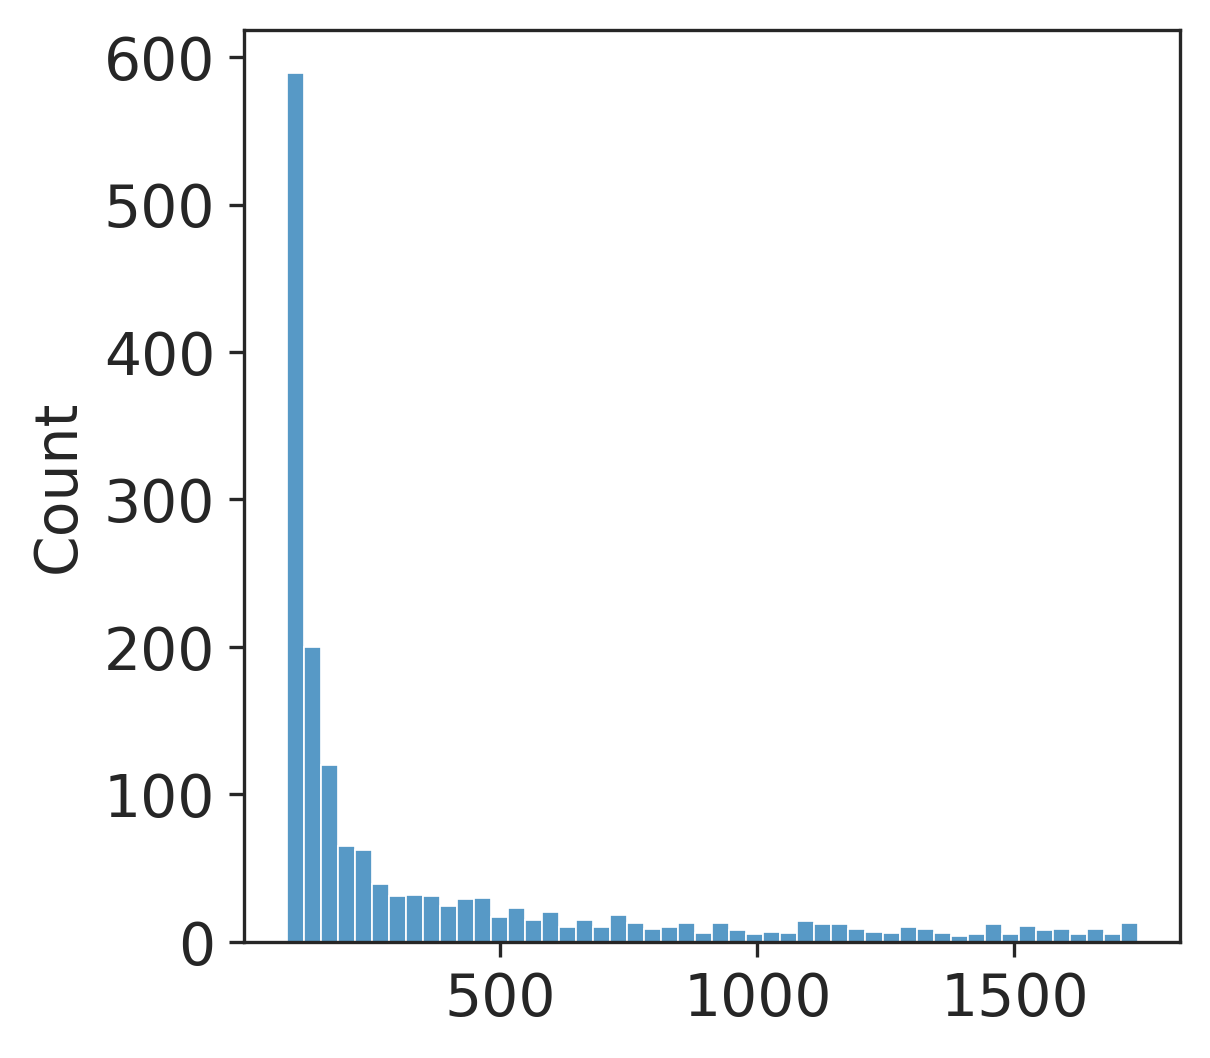

In [84]:
sns.histplot(adata.X.sum(axis=1).A.T[0][pred == 2], bins=50)

Мы получили очень плохой результат, перемешав средние распределений. Алгоритм в этом случае ведет себя не очень.

### Выполним вторую проверку с значениями мат ожидания

Сделаем значения мат ожиданий распределений похожими и посмотрим, как это влияет на качество кластеризации.

phi_real: 0.11704941826439122
phi_empty: 0.4414752908678044
mu_real: 8.85366542803745
mu_int: 8.517193191416238
mu_empty: 7.824046010856292
sigma_real: 1
sigma_int: 1
sigma_empty: 1


Text(0.5, 1.0, 'Start position')

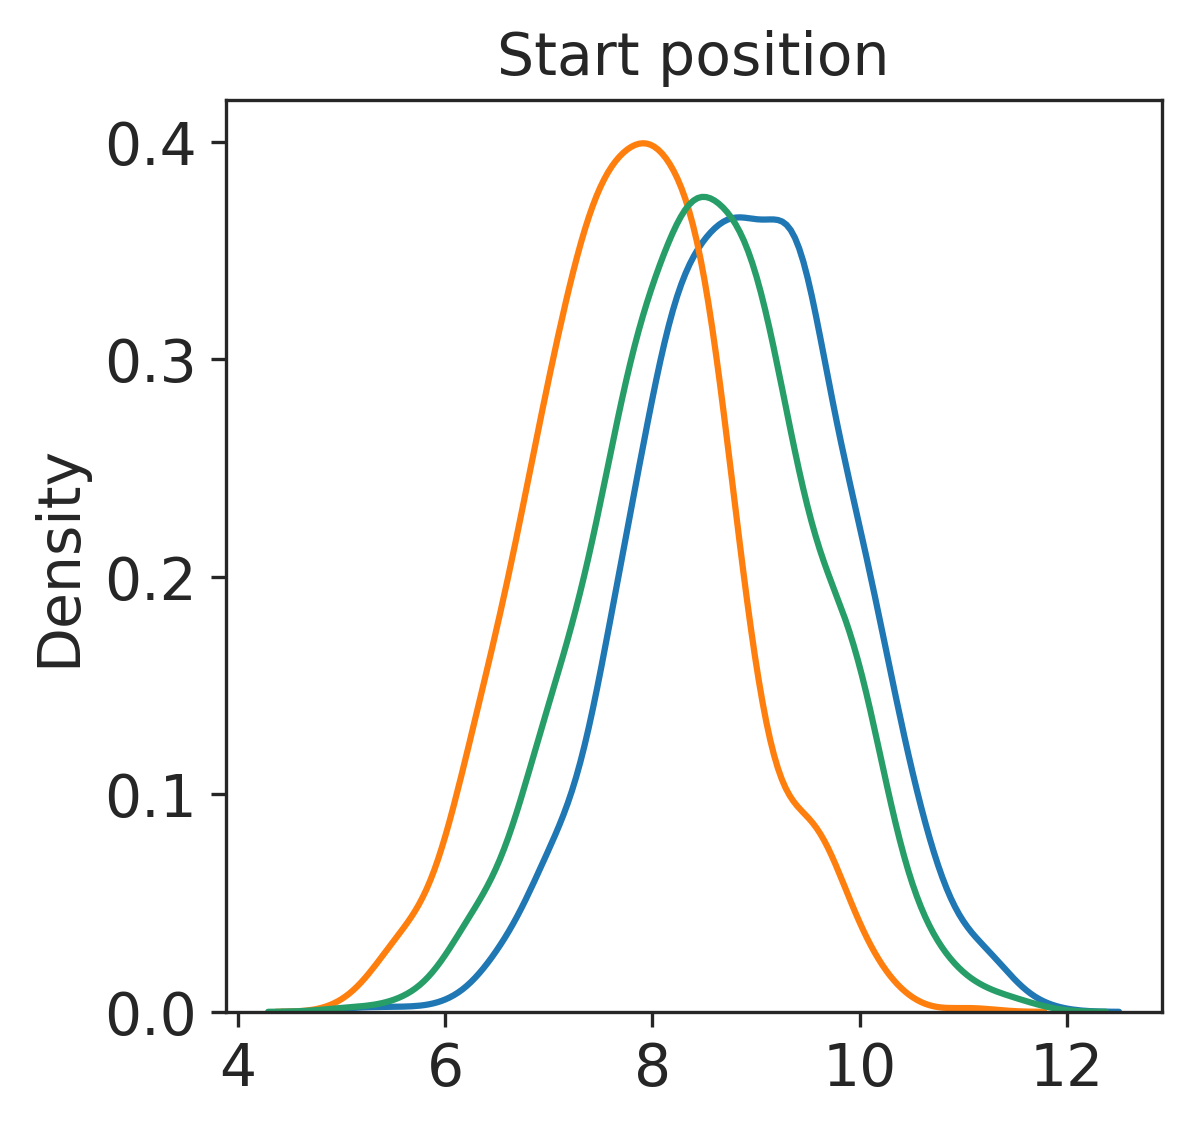

In [78]:
X = np.log(adata.X.sum(axis=1).A.T[0])
expected_cells = 10000 / len(adata)

params = {
  "phi_real" : expected_cells,
  "phi_empty" : (1 - expected_cells) / 2,
  "mu_real" : np.log(7000),
  "mu_int" : np.log(5000),
  "mu_empty" : np.log(2500),
  "sigma_real" : 1,
  "sigma_int" : 1,
  "sigma_empty" : 1
}

for param in params:
  print(f"{param}: {params[param]}")

params_start = params.copy()

start_real = stats.norm(params["mu_real"], params["sigma_real"]).rvs(size=1000)
start_int = stats.norm(params["mu_int"], params["sigma_int"]).rvs(size=1000)
start_empty = stats.norm(params["mu_empty"], params["sigma_empty"]).rvs(size=1000)

ax = sns.kdeplot(start_real)
ax = sns.kdeplot(start_empty)
ax = sns.kdeplot(start_int)
ax.set_title("Start position")

Text(0.5, 1.0, 'Final position')

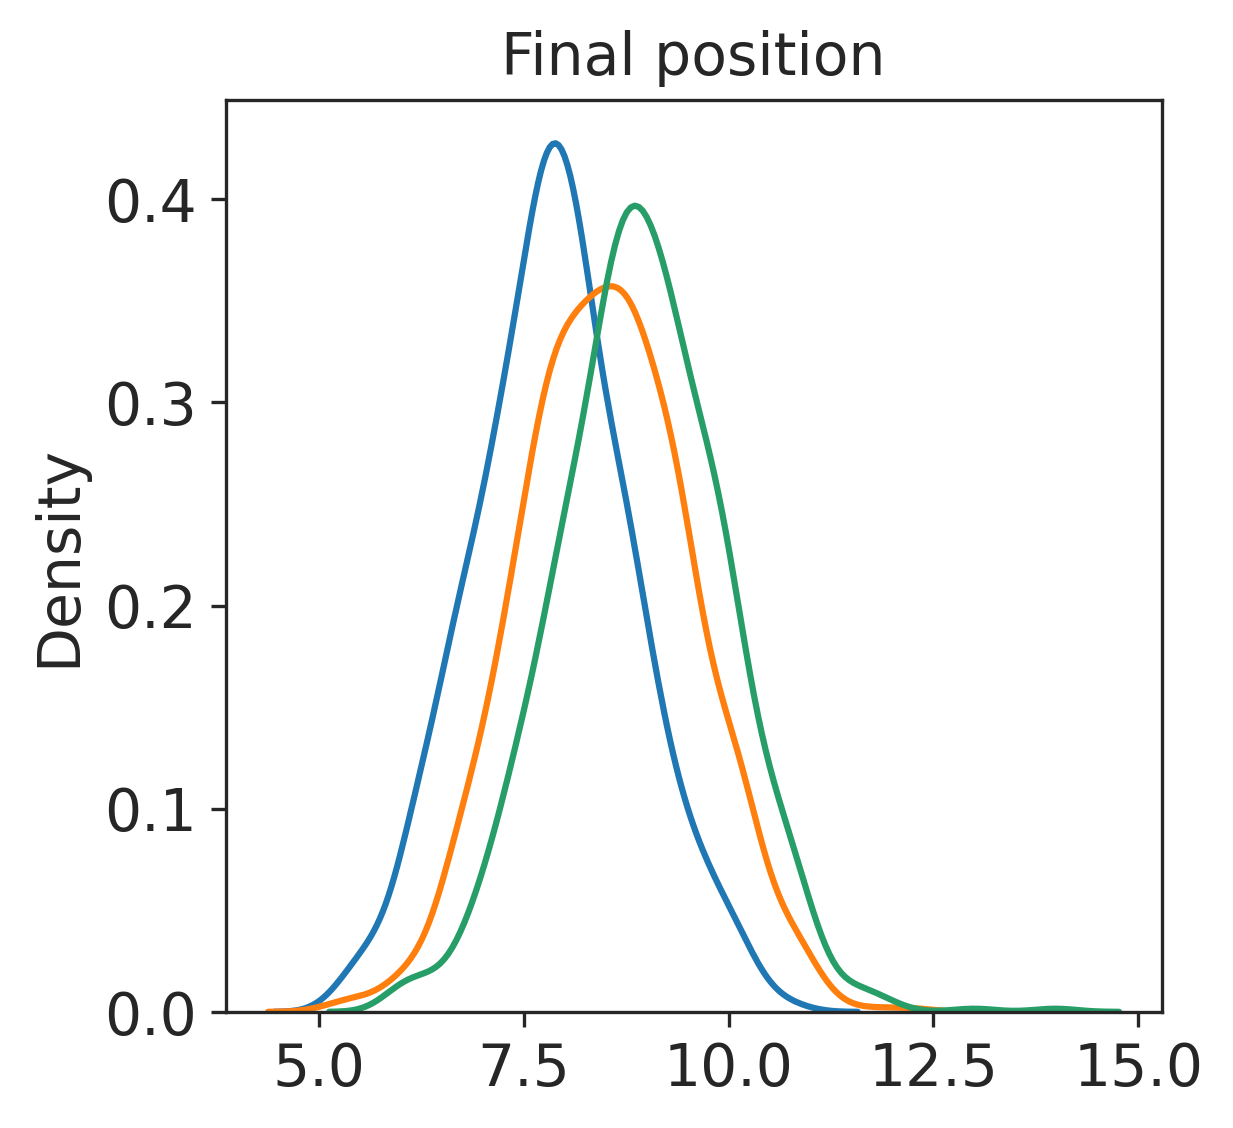

In [79]:
pred, prob, avg_allprob = run_EM(X, params)
final_real = stats.norm(params["mu_real"], params["sigma_real"]).rvs(size=1000)
final_int = stats.norm(params["mu_int"], params["sigma_int"]).rvs(size=1000)
final_empty = stats.norm(params["mu_empty"], params["sigma_empty"]).rvs(size=1000)

ax = sns.kdeplot(final_empty)
ax = sns.kdeplot(final_int)
ax = sns.kdeplot(final_real)
ax.set_title("Final position")

<AxesSubplot: ylabel='Count'>

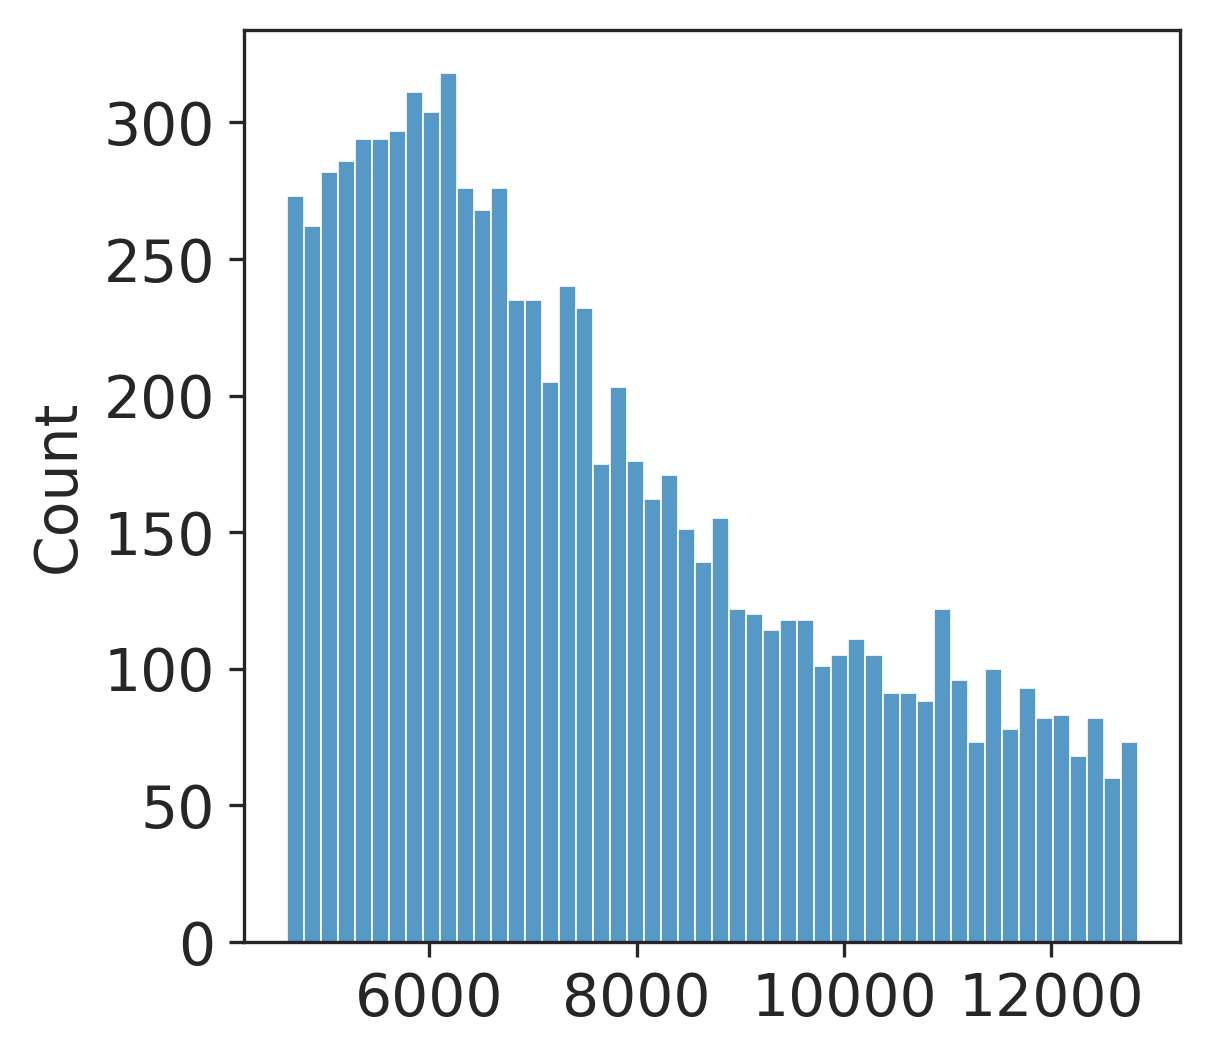

In [80]:
sns.histplot(adata.X.sum(axis=1).A.T[0][pred == 2], bins=50)

EM-алгоритм в случае его инициализации близкими значениями мат ожиданий распределений ведет себя плохо. Результат лучше, чем в предыдущей проверке. Но мы получили клетки с 12000-13000 каунтов, хотя изменения средних значения количество каунтов у некоторых клеток доходило до 30000. То есть в данном случае мы потеряли львиную долю данных.

### Выполним вторую проверку с дисперсией

Сделаем дисперсию трех распределений одинаковой и увеличим ее

phi_real: 0.11704941826439122
phi_empty: 0.4414752908678044
mu_real: 9.210340371976184
mu_int: 6.214608098422191
mu_empty: 2.302585092994046
sigma_real: 4
sigma_int: 4
sigma_empty: 4


Text(0.5, 1.0, 'Start position')

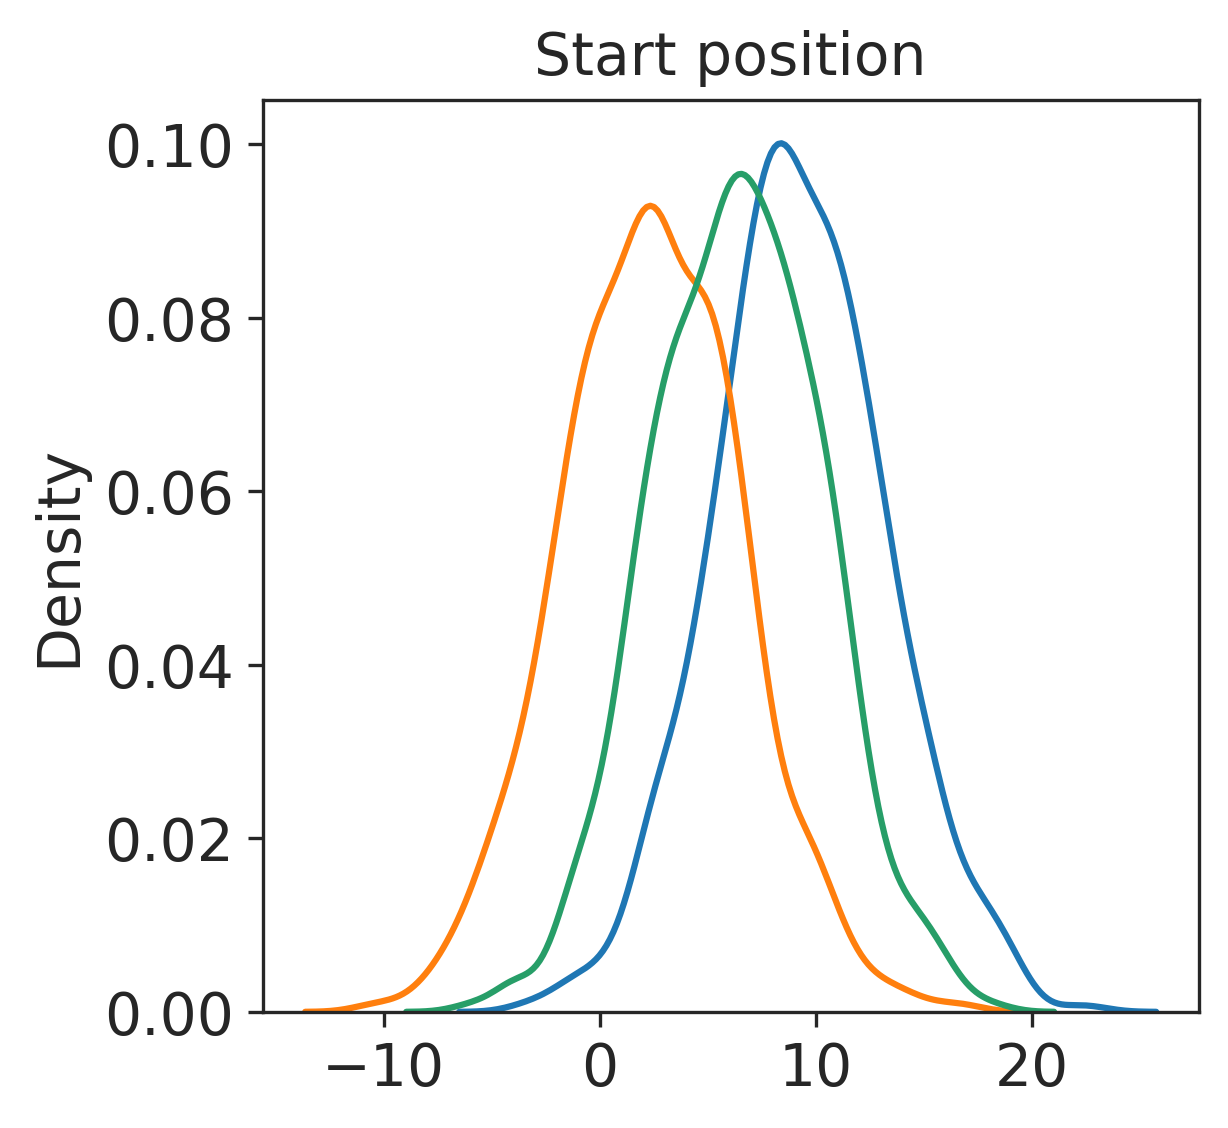

In [62]:
X = np.log(adata.X.sum(axis=1).A.T[0])
expected_cells = 10000 / len(adata)

params = {
  "phi_real" : expected_cells,
  "phi_empty" : (1 - expected_cells) / 2,
  "mu_real" : np.log(10000),
  "mu_int" : np.log(500),
  "mu_empty" : np.log(10),
  "sigma_real" : 4,
  "sigma_int" : 4,
  "sigma_empty" : 4
}

for param in params:
  print(f"{param}: {params[param]}")

params_start = params.copy()

start_real = stats.norm(params["mu_real"], params["sigma_real"]).rvs(size=1000)
start_int = stats.norm(params["mu_int"], params["sigma_int"]).rvs(size=1000)
start_empty = stats.norm(params["mu_empty"], params["sigma_empty"]).rvs(size=1000)

ax = sns.kdeplot(start_real)
ax = sns.kdeplot(start_empty)
ax = sns.kdeplot(start_int)
ax.set_title("Start position")

Text(0.5, 1.0, 'Final position')

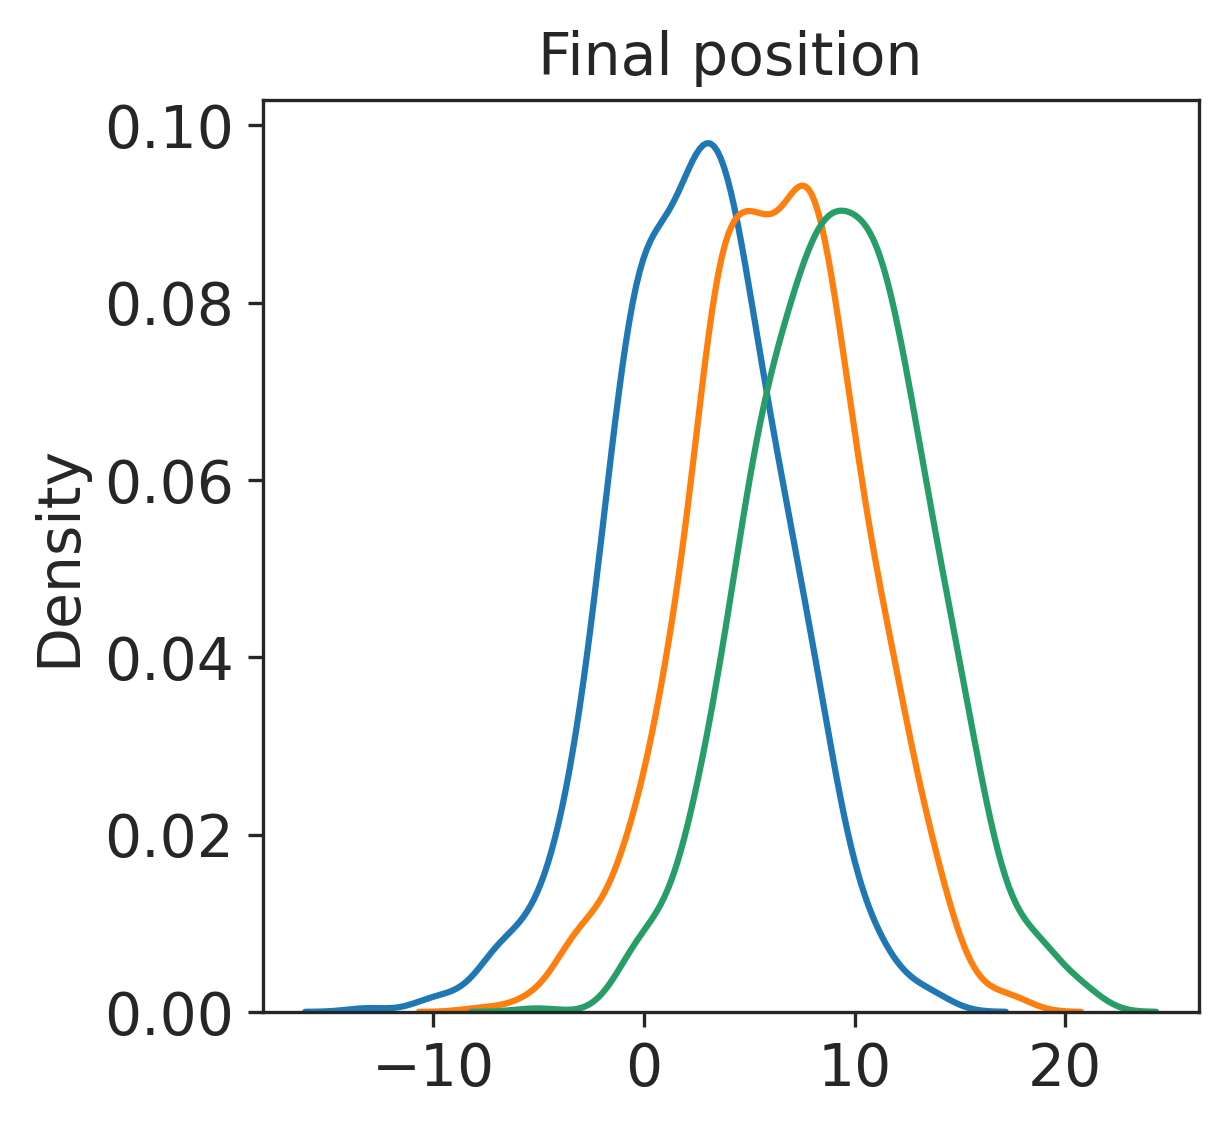

In [63]:
pred, prob, avg_allprob = run_EM(X, params)
final_real = stats.norm(params["mu_real"], params["sigma_real"]).rvs(size=1000)
final_int = stats.norm(params["mu_int"], params["sigma_int"]).rvs(size=1000)
final_empty = stats.norm(params["mu_empty"], params["sigma_empty"]).rvs(size=1000)

ax = sns.kdeplot(final_empty)
ax = sns.kdeplot(final_int)
ax = sns.kdeplot(final_real)
ax.set_title("Final position")

<AxesSubplot: ylabel='Count'>

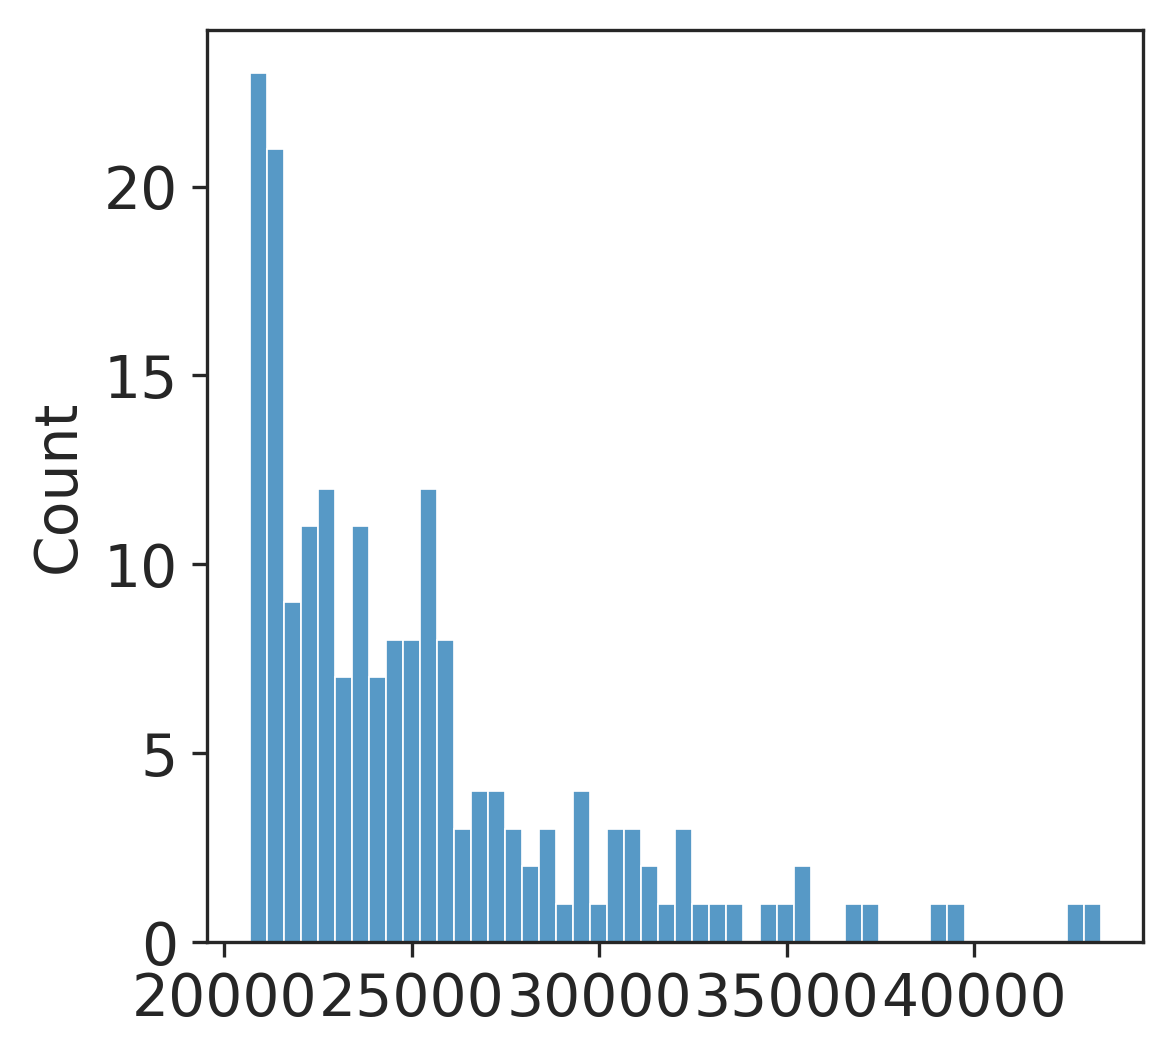

In [64]:
sns.histplot(adata.X.sum(axis=1).A.T[0][pred == 2], bins=50)

В этом случае мы получили некоторые клетки с большим числом прочтений. Но данные прочтения могут включать в себя дуплеты, то есть качество данных сильно понизилось. Эта ситуация намного хуже, чем две предыдущих, так как лучше анализировать небольшое число качественных данных, чем большое число некачественных.

### Выполним третью проверку с изменением дисперсии и мат ожидания

Перемещаем мат ожидания, сделаем их примерно одинаковыми. А также установим одинаковую дисперсию для всех расрпеделений.

phi_real: 0.11704941826439122
phi_empty: 0.4414752908678044
mu_real: 8.85366542803745
mu_int: 8.006367567650246
mu_empty: 7.313220387090301
sigma_real: 4
sigma_int: 4
sigma_empty: 4


Text(0.5, 1.0, 'Start position')

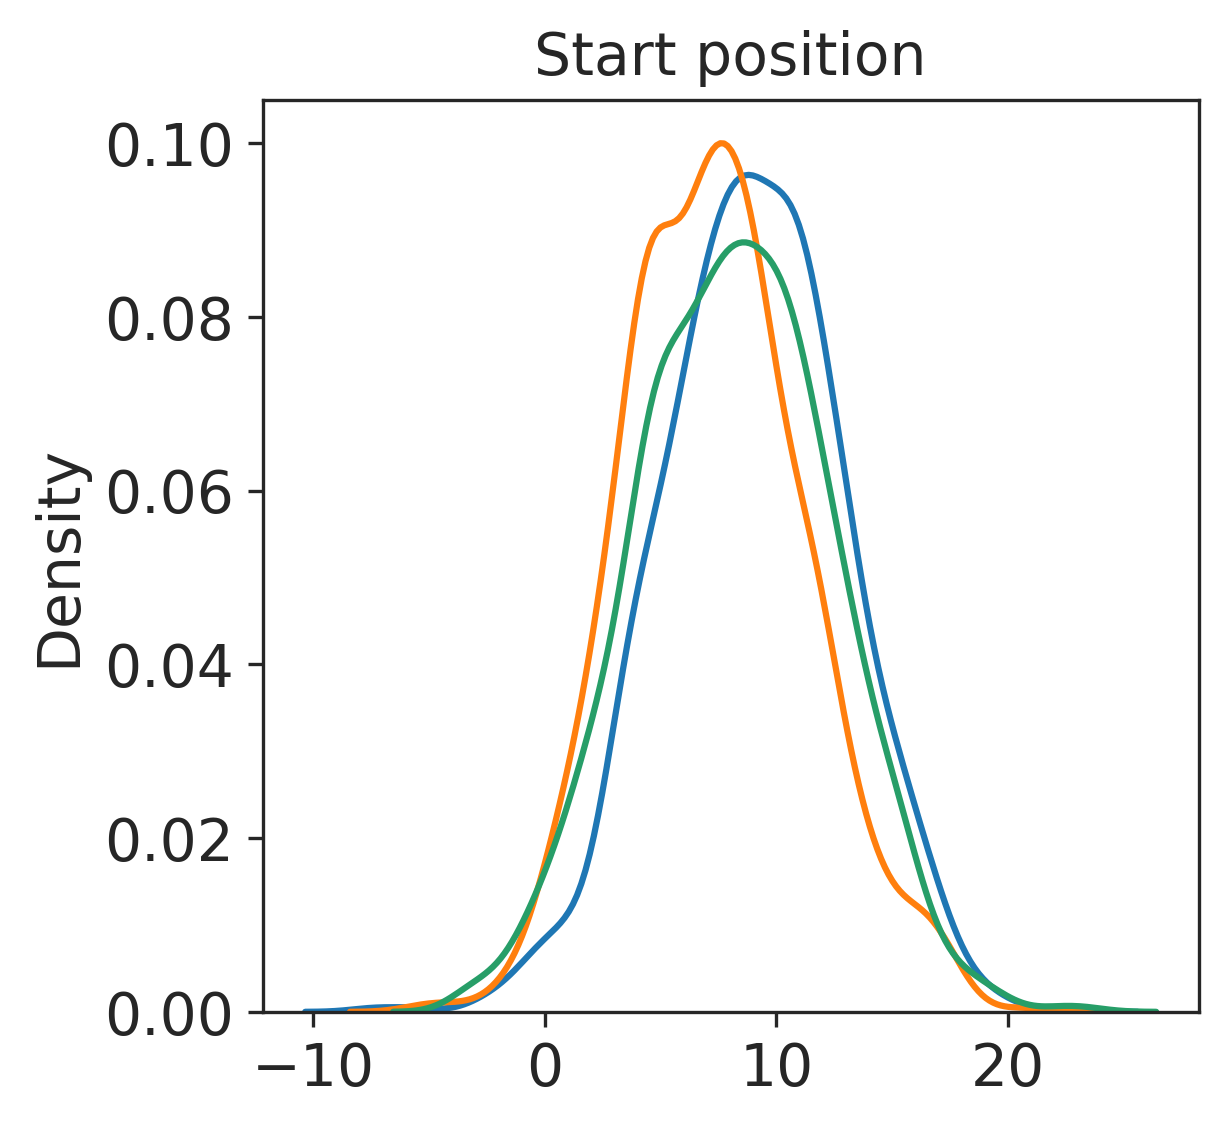

In [85]:
X = np.log(adata.X.sum(axis=1).A.T[0])
expected_cells = 10000 / len(adata)

params = {
  "phi_real" : expected_cells,
  "phi_empty" : (1 - expected_cells) / 2,
  "mu_real" : np.log(7000),
  "mu_int" : np.log(3000),
  "mu_empty" : np.log(1500),
  "sigma_real" : 4,
  "sigma_int" : 4,
  "sigma_empty" : 4
}

for param in params:
  print(f"{param}: {params[param]}")

params_start = params.copy()

start_real = stats.norm(params["mu_real"], params["sigma_real"]).rvs(size=1000)
start_int = stats.norm(params["mu_int"], params["sigma_int"]).rvs(size=1000)
start_empty = stats.norm(params["mu_empty"], params["sigma_empty"]).rvs(size=1000)

ax = sns.kdeplot(start_real)
ax = sns.kdeplot(start_empty)
ax = sns.kdeplot(start_int)
ax.set_title("Start position")

Text(0.5, 1.0, 'Final position')

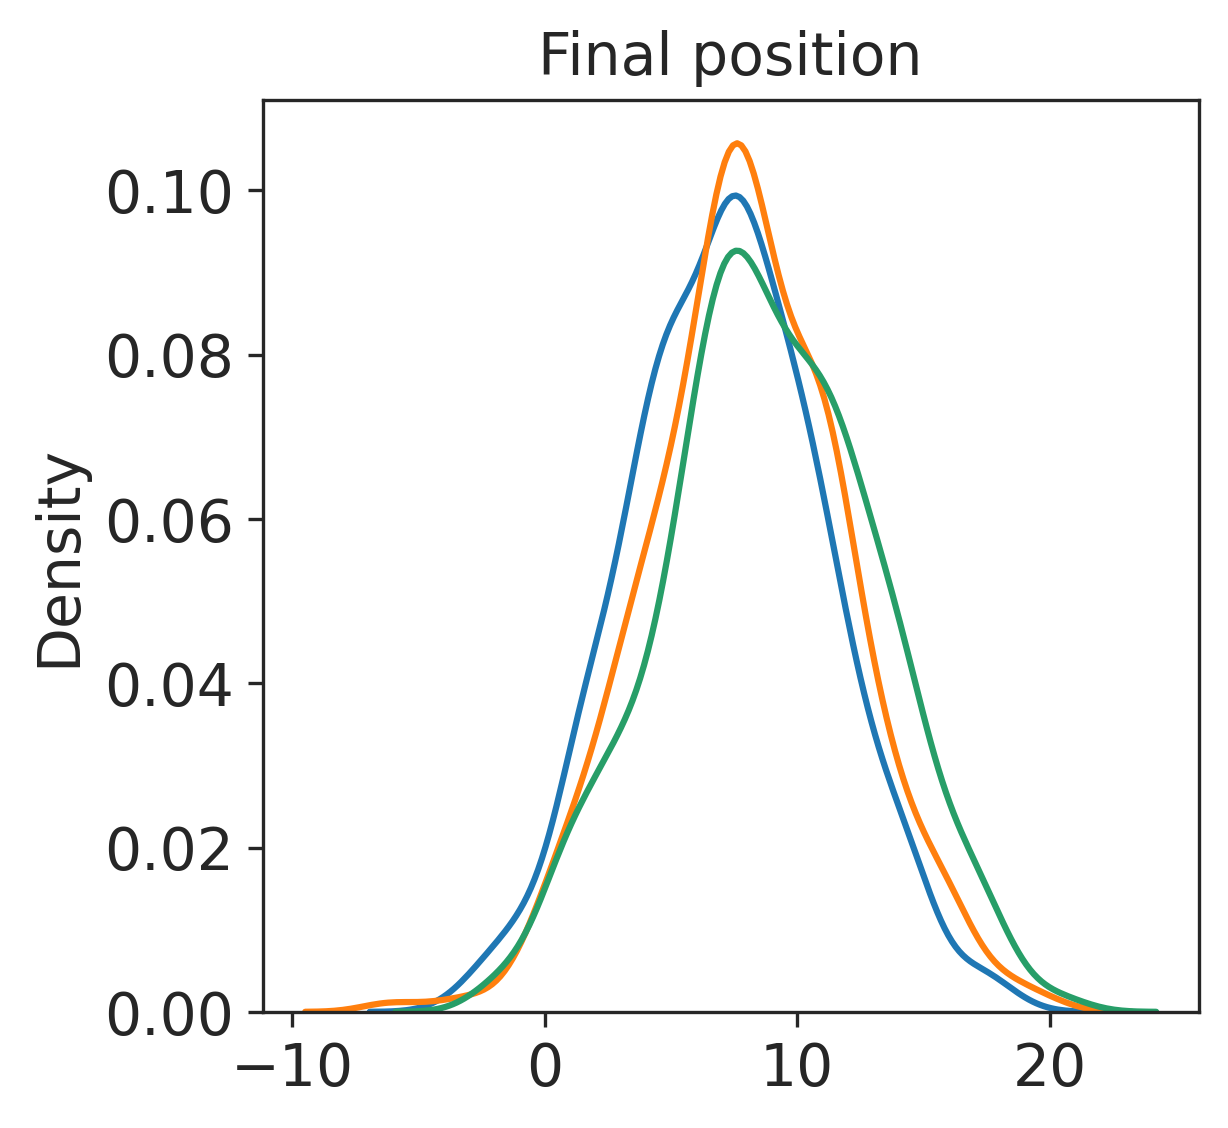

In [86]:
pred, prob, avg_allprob = run_EM(X, params)
final_real = stats.norm(params["mu_real"], params["sigma_real"]).rvs(size=1000)
final_int = stats.norm(params["mu_int"], params["sigma_int"]).rvs(size=1000)
final_empty = stats.norm(params["mu_empty"], params["sigma_empty"]).rvs(size=1000)

ax = sns.kdeplot(final_empty)
ax = sns.kdeplot(final_int)
ax = sns.kdeplot(final_real)
ax.set_title("Final position")

<AxesSubplot: ylabel='Count'>

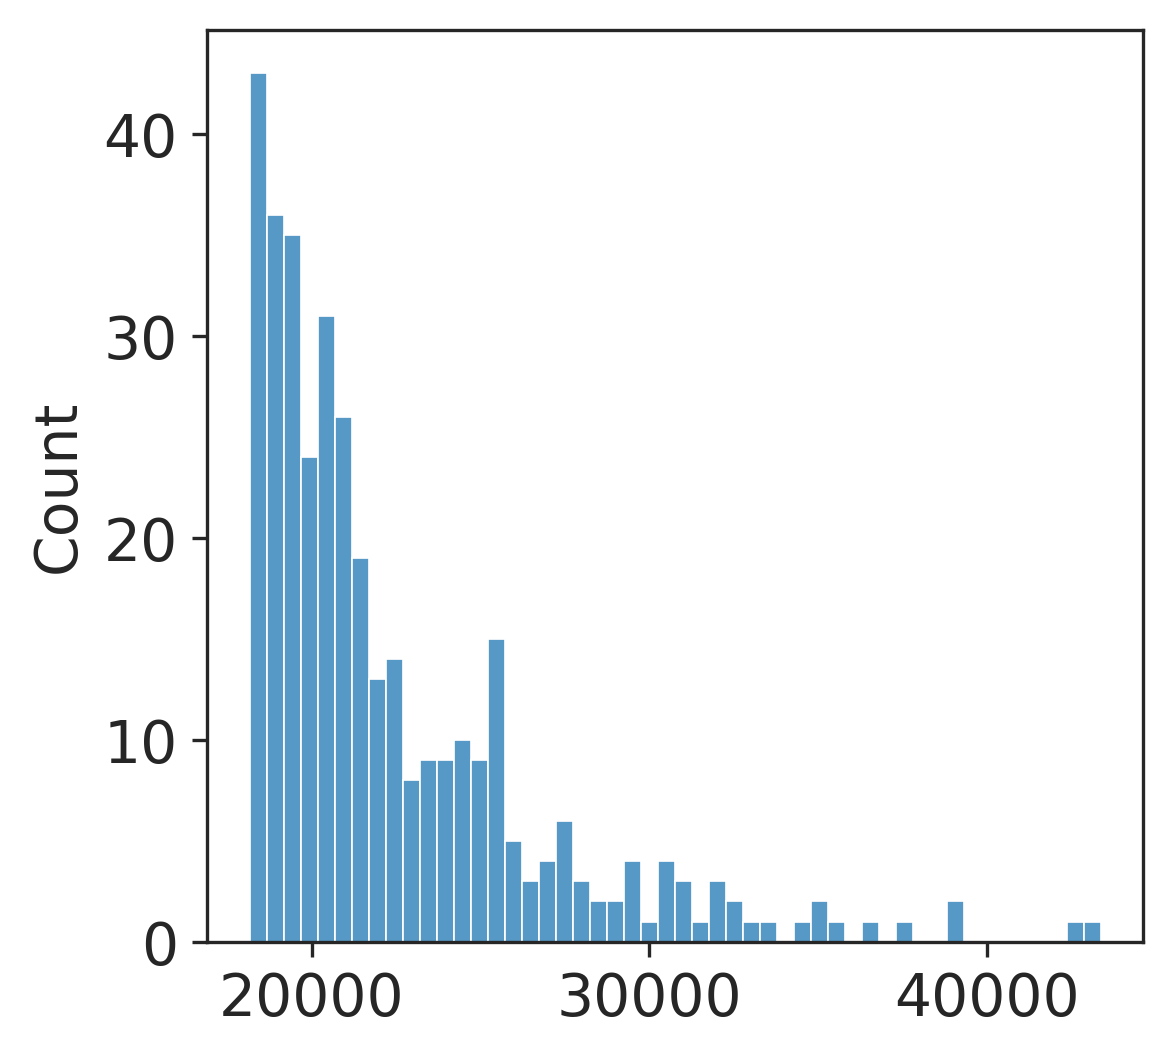

In [87]:
sns.histplot(adata.X.sum(axis=1).A.T[0][pred == 2], bins=50)

Данная ситуация похожа на предыдущую. Мы получили чуть большее количество клеток, чем планировали. 

### Задание 2

Напишите NextFlow-пайплайн, который бы включал в себя определение экспрессий при помощи `kallisto | bustools`, а потом устранение дублетов при помощи DropletUtils.

## Решение

Составим `nextflow` скрипт, который будет скачивать `.fastq` scRNA-seq данные, рассчитывать на основе этих данных экспрессии и удалять дублеты при помощи `R` скрипта.

Скачаем необходимые библиотеки для `R`

In [ ]:
!Rscript -e 'BiocManager::install("zellkonverter")'
!Rscript -r 'BiocManager::install("DropletUtils")'

Проверим, установились ли эти библиотеки

In [ ]:
%%R

library(zellkonverter)
library(DropletUtils)

Составим `.nf` пайплайн.

Данный паплайн скачивает `.fastq` файлы, на их основе проводит рассчет экспрессии с помощью kallsto | bustools и c помощью заранее написанного `R` скрипта проводит очистку данных экспрессии от дублетов.

```R
#!/usr/local/bin Rscript

library(zellkonverter)
library(DropletUtils)

# load arguments from the command line to this script
args = commandArgs(trailingOnly=TRUE)

# obtaining a H5AD file with scRNA-seq expressions.
example_h5ad <- system.file("extdata", args, package = "zellkonverter")
input_h5ad = readH5AD(example_h5ad)

# clearing expressions from duplicates
output_h5ad <- emptyDrops(assay(input_h5ad))

# saving of expressions cleared of duplicates
writeH5AD(output_h5ad, "output.h5ad")
```

```nextflow
params.results_dir = "results/"
SRA_list = params.SRA.split(",")
params.index = "/content/transcriptome.idx"
params.r_script = "/content/dropletutils_script.R"

log.info ""
log.info "  Q U A L I T Y   C O N T R O L  "
log.info "================================="
log.info "SRA number         : ${SRA_list}"
log.info "Results location   : ${params.results_dir}"

// Downloading .fastq files by the fasterq-dump tool of the sratoolkit
process DownloadFastQ {
  publishDir "${params.results_dir}"

  input:
    val sra

  output:
    path "${sra}/*"

  script:
    """
    /content/sratoolkit.3.0.0-ubuntu64/bin/fasterq-dump ${sra} -O ${sra}/
    """
}

// Kallisto | Bustools process, which evaluate gene expressions by the pseudoalignment and save expressions in .h5ad file
process KalistoBustools {
  publishDir "${params.results_dir}"

  input:
    path x

  output:
    path "kalisto_bustools/*"

  script:
    """
    mkdir kalisto_bustools
    /content/kallisto/build/src/kb count -i ${params.index} -o kalisto_bustools -x 10xv3 --h5ad $x
    """
}

// DropletUtils process deleted droplet from expressions
process DropletUtils {
  publishDir "${params.results_dir}"

  input:
    path x

  output:
    path "*.h5ad"

  script:
    """
    /usr/local/bin/Rscript ${params.r_script} ${x}
    """
}

workflow {
  data = Channel.of( SRA_list )
  DownloadFastQ( data )
  KalistoBustools( DownloadFastQ.out )
  DropletUtils( KalistoBus.out )
}
```